<a href="https://colab.research.google.com/github/s-kp/CapstoneProject-FaceEmotionRecognition/blob/main/FER_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Table of Contents**

- [Project Introduction](#1)
- [Importing Dependencies](#2)
- [Defining Prerequisites](#3)
- [Modified LeNet](#4)
- [AlexNet](#5)
- [MobileNetV2](#6)
- [VGG16](#7)
- [VGG19](#8)
- [Custom Model](#9)
- [Basic Inception](#10)
- [ResNet](#11)



<a name='1'></a>
# **Project Introduction**


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

## **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

**Face Emotion Recognition:**
This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.

<a name='2'></a>
# **Importing Dependencies**

In [ ]:
# Importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19, ResNet152
from keras.models import Sequential, load_model
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os 

# DND Mode
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)

In [ ]:
# Importing the drive to save trained models
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Downloading the dataset
!gdown --id 1kdAI0wrR_bTBs-6pbKB6giz-JcNaTY-s

# Unzipping the files
!unzip '/content/dataset.zip'

In [ ]:
# Defining te path of train and test dataset
train_dir = '/content/train'
test_dir = '/content/test'

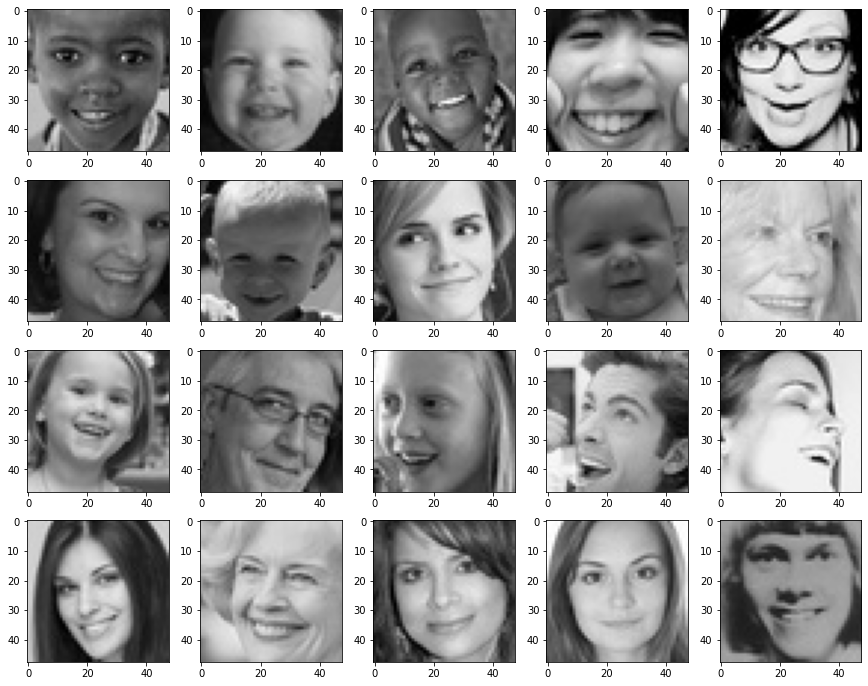

In [ ]:
# Displaying sample Images
path = '/content/train/happy/'
plt.figure(figsize=(15,12))
for i in range(1, 21):
    plt.subplot(4,5,i)
    img = load_img(path + os.listdir(path)[i])
    plt.imshow(img)   
plt.show()

In [ ]:
# Number of train images for each expression
base_path = "/content/"
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

4830 sad images
4097 fear images
7215 happy images
3171 surprise images
436 disgust images
4965 neutral images
3995 angry images


In [ ]:
# Generating batches of tensor image data with real-time data augmentation.

batch = 64 # setting the batch size for mini batch
img = (48,48) # setting the dimensions for image
color = "grayscale" # setting the color mode for images

# Setting the Data Augumentation parameters for validation data set 
valid_gen = ImageDataGenerator(rescale=1./255)
# Setting the Data Augumentation parameters for training data set 
train_gen = ImageDataGenerator(rotation_range=20, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True,
                              width_shift_range=0.1, height_shift_range=0.1)

# Fetching the files from train directory and performing the data augumentation
train_data = train_gen.flow_from_directory(train_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")
# Fetching the files from test directory and performing the data augumentation
validation = valid_gen.flow_from_directory(test_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


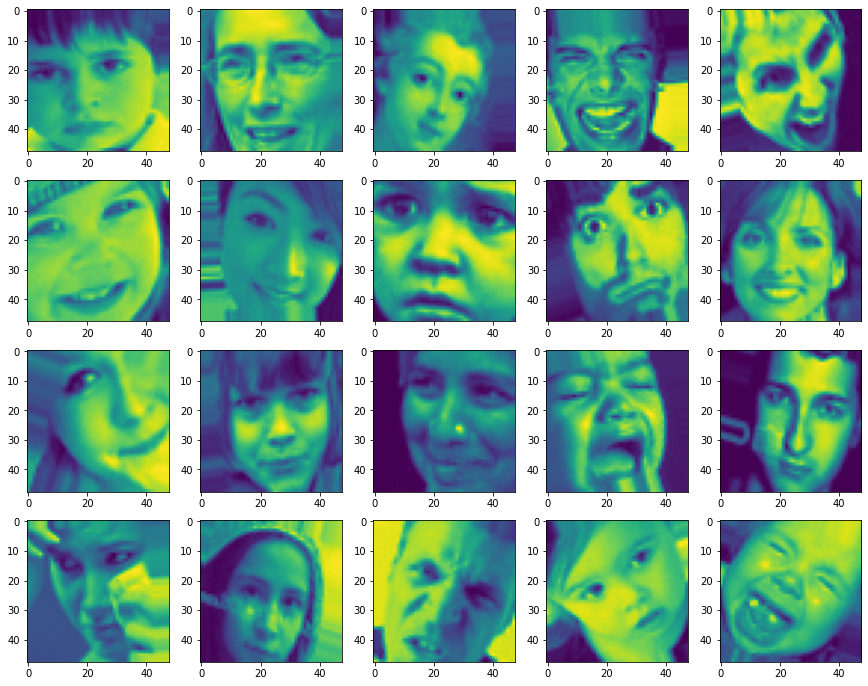

In [ ]:
# Displaying sample images from the training set after augmentation
random_image = np.random.choice(64, size=20, replace=False)
random_batch = np.random.choice(112,size=20, replace=False)
fig,axes=plt.subplots(4,5,figsize=(15,12))
for id, ax in enumerate(axes.flatten()):
  pic = train_data[random_batch[id]][0][random_image[id]]
  ax.imshow(pic.reshape(48,-1))

In [ ]:
# checking te shape of image and the label
image_batch, label_batch = next(iter(train_data))
print('image shape',image_batch[0].shape)
print('Label shape',label_batch[0].shape)

image shape (48, 48, 1)
Label shape (7,)


<a name='3'></a>
# **Defining prerequisites**

In [ ]:
# Defining a function to generate callbacks
def callback_list(name, esp=9, lrp=3):
    ''' Defining a function to generate the list of callbacks
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''
    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/{name}.h5", monitor='val_acc', mode='max', save_best_only=True, verbose=1)
    # Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=esp, verbose=1, restore_best_weights=True)
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=lrp, verbose=1, min_delta=0.0001)
    # Defining a list of all the callbacks
    callbacks = [earlystop, checkpoint, reduce_lr]

    return callbacks

In [ ]:
# Plot the training and validation accuracy and loss
def plots(history):
    ''' Defining a function to Plot the accuracy and loss
    Arguments:
        model.history
    Returns:
        plots of accuracy and loss for train and validation data
    '''
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# Defining a function to plot the confusion matrix
def plotc(model, model_name='Model', test_data_gen = validation):
    ''' Defining a function to display the confusion matrix
    Arguments:
        model -- model.h5
        model_name -- name of the model
        test_data_gen -- test data generator object
    Returns:
        Plots theConfusion Matrix
    '''
    # compute predictions
    predictions = model.predict_generator(generator=test_data_gen)
    y_pred = [np.argmax(probas) for probas in predictions]
    y_test = test_data_gen.classes
    classes = test_data_gen.class_indices.keys()

    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plotting confusion matrix
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(f'{model_name} Confusion Matrix'.title())
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks+0.5, classes, rotation=45)
    plt.yticks(tick_marks+0.5, classes, rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
# %%shell
# cp /content/drive/MyDrive/Colab\ Notebooks/Capstone\ Projects/Face\ Emotion\ Recognition\ -\ Sushwet\ Kumar\ Pandey/Models/* /content/

<a name='4'></a>
# **Modified LeNet**

In [ ]:
# Defining modeified Lenet architecture using keras sequential API
lenet = Sequential([# First CNN layer
                    Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # Second CNN layer
                    Conv2D(filters=16, kernel_size=3, activation='relu',  padding='same'),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # flattening and Adding 2 fully connected layers
                    Flatten(),
                    Dense(120, activation='relu'),
                    Dense(84, activation='relu'),
                    # using a prediction layer with seven neuron 
                    Dense(7, activation='softmax')])

# Compiling the model
lenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
lenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 48, 48, 6)         60        
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 6)        24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 6)        0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 16)        880       
                                                                 
 batch_normalization_8 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                      

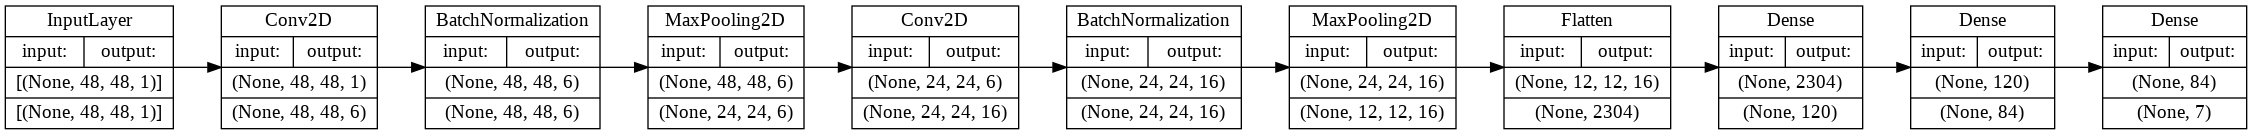

In [ ]:
# Plot model graph
plot_model(lenet, show_shapes=True, to_file='lenet.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
lenet_history = lenet.fit_generator(generator=train_data,
                                    steps_per_epoch=train_data.n//train_data.batch_size,
                                    epochs=50,
                                    validation_data = validation,
                                    validation_steps = validation.n//validation.batch_size,
                                    callbacks=callback_list('lenet')
                                    )

Epoch 1/50
448/448 [==============================] - 27s 58ms/step - loss: 1.8156 - accuracy: 0.2650 - val_loss: 1.7609 - val_accuracy: 0.3012 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - 25s 55ms/step - loss: 1.7283 - accuracy: 0.3019 - val_loss: 1.6698 - val_accuracy: 0.3511 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - 27s 59ms/step - loss: 1.6941 - accuracy: 0.3238 - val_loss: 1.6362 - val_accuracy: 0.3651 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - 30s 66ms/step - loss: 1.6745 - accuracy: 0.3365 - val_loss: 1.6288 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - 28s 61ms/step - loss: 1.6528 - accuracy: 0.3466 - val_loss: 1.5803 - val_accuracy: 0.3880 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - 28s 63ms/step - loss: 1.6333 - accuracy: 0.3572 - val_loss: 1.5500 - val_accuracy: 0.3994 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============

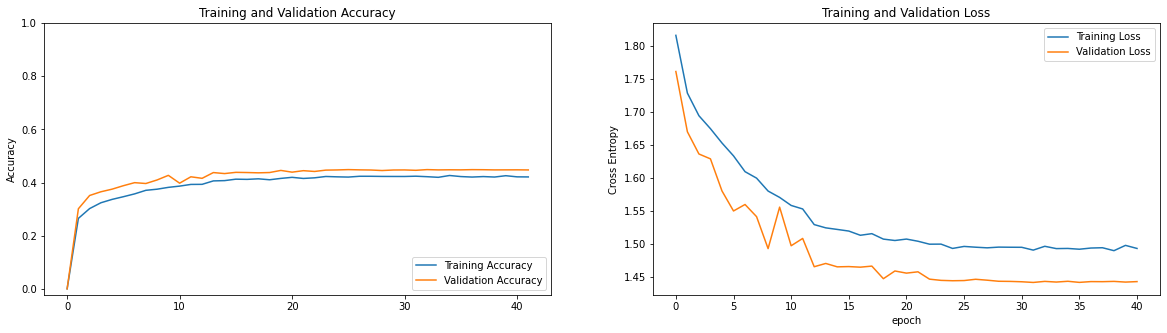

In [ ]:
# Plotting the accuracy and loss
plots(lenet_history)

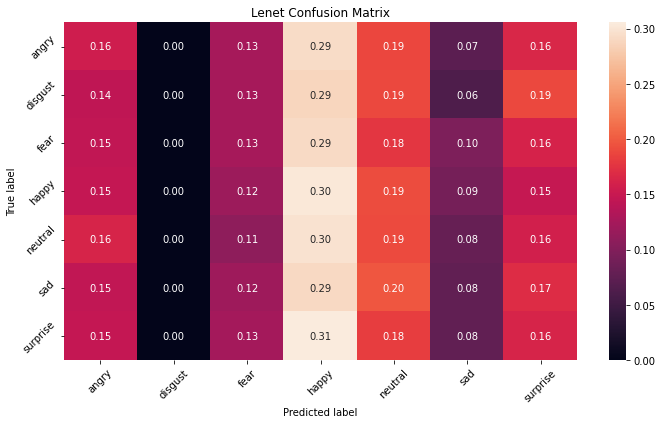

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=lenet, model_name='lenet')

In [ ]:
# Saving the model
lenet.save('/content/drive/MyDrive/lenet.h5')

<a name='5'></a>
# **Alexnet**

In [ ]:
# AlexNet CNN architecture from scratch using keras sequential API
alexnet = Sequential([# The first block with 1 conv
                      Conv2D(96, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The second block with 1 conv
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The third block with 3 conv
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      MaxPool2D(pool_size=(2,2)),
                      # Flattening and Using 2 fully connected layer with 4096 units and relu activation
                      Flatten(),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      # Using a prediction layer with seven neuron
                      Dense(7, activation='softmax')])

# Compiling the model
alexnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 48, 48, 96)        960       
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 24, 24, 256)       221440    
                                                                 
 batch_normalization_10 (Bat  (None, 24, 24, 256)      1024      
 chNormalization)                                                
                                                      

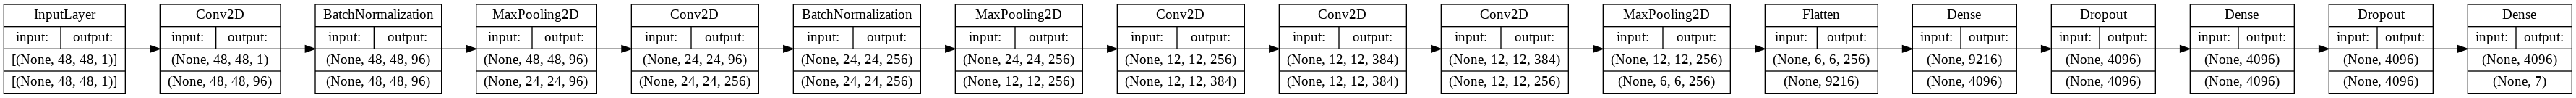

In [ ]:
# Plot model graph
plot_model(alexnet, to_file='alexnet.png', show_shapes=True, rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
alexnet_history = alexnet.fit_generator(generator=train_data,
                                        steps_per_epoch=train_data.n//train_data.batch_size,
                                        epochs=50,
                                        validation_data = validation,
                                        validation_steps = validation.n//validation.batch_size,
                                        callbacks=callback_list('alexnet')
                                        )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.7510 - accuracy: 0.2902WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 36s 77ms/step - loss: 1.7510 - accuracy: 0.2902 - val_loss: 1.7019 - val_accuracy: 0.3380 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.5187 - accuracy: 0.4085WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.5187 - accuracy: 0.4085 - val_loss: 1.3568 - val_accuracy: 0.4812 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.3719 - accuracy: 0.4708WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.3719 - accuracy: 0.4708 - val_loss: 1.2491 - val_accuracy: 0.5275 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.2900 - accuracy: 0.5061WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 77ms/step - loss: 1.2900 - accuracy: 0.5061 - val_loss: 1.1808 - val_accuracy: 0.5502 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - ETA: 0s - loss: 1.2329 - accuracy: 0.5295WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 1.2329 - accuracy: 0.5295 - val_loss: 1.1418 - val_accuracy: 0.5608 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - ETA: 0s - loss: 1.1914 - accuracy: 0.5466WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 72ms/step - loss: 1.1914 - accuracy: 0.5466 - val_loss: 1.1059 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============================] - ETA: 0s - loss: 1.1560 - accuracy: 0.5614WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.1560 - accuracy: 0.5614 - val_loss: 1.0925 - val_accuracy: 0.5801 - lr: 1.0000e-04
Epoch 8/50
448/448 [==============================] - ETA: 0s - loss: 1.1294 - accuracy: 0.5719WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 79ms/step - loss: 1.1294 - accuracy: 0.5719 - val_loss: 1.0834 - val_accuracy: 0.5871 - lr: 1.0000e-04
Epoch 9/50
448/448 [==============================] - ETA: 0s - loss: 1.1034 - accuracy: 0.5842WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 70ms/step - loss: 1.1034 - accuracy: 0.5842 - val_loss: 1.1516 - val_accuracy: 0.5643 - lr: 1.0000e-04
Epoch 10/50
448/448 [==============================] - ETA: 0s - loss: 1.0808 - accuracy: 0.5910WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 75ms/step - loss: 1.0808 - accuracy: 0.5910 - val_loss: 1.0364 - val_accuracy: 0.6122 - lr: 1.0000e-04
Epoch 11/50
448/448 [==============================] - ETA: 0s - loss: 1.0612 - accuracy: 0.5996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 37s 82ms/step - loss: 1.0612 - accuracy: 0.5996 - val_loss: 1.0669 - val_accuracy: 0.5981 - lr: 1.0000e-04
Epoch 12/50
448/448 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.6048WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 79ms/step - loss: 1.0440 - accuracy: 0.6048 - val_loss: 1.0132 - val_accuracy: 0.6176 - lr: 1.0000e-04
Epoch 13/50
448/448 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.6113WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 75ms/step - loss: 1.0280 - accuracy: 0.6113 - val_loss: 1.0862 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 14/50
448/448 [==============================] - ETA: 0s - loss: 1.0131 - accuracy: 0.6145WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 72ms/step - loss: 1.0131 - accuracy: 0.6145 - val_loss: 1.0198 - val_accuracy: 0.6211 - lr: 1.0000e-04
Epoch 15/50
448/448 [==============================] - ETA: 0s - loss: 0.9936 - accuracy: 0.6257WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 15: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 35s 78ms/step - loss: 0.9936 - accuracy: 0.6257 - val_loss: 1.0427 - val_accuracy: 0.6136 - lr: 1.0000e-04
Epoch 16/50
448/448 [==============================] - ETA: 0s - loss: 0.9345 - accuracy: 0.6481WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 0.9345 - accuracy: 0.6481 - val_loss: 0.9928 - val_accuracy: 0.6314 - lr: 2.0000e-05
Epoch 17/50
448/448 [==============================] - ETA: 0s - loss: 0.9182 - accuracy: 0.6527WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.9182 - accuracy: 0.6527 - val_loss: 1.0162 - val_accuracy: 0.6275 - lr: 2.0000e-05
Epoch 18/50
448/448 [==============================] - ETA: 0s - loss: 0.9062 - accuracy: 0.6597WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 0.9062 - accuracy: 0.6597 - val_loss: 1.0044 - val_accuracy: 0.6324 - lr: 2.0000e-05
Epoch 19/50
448/448 [==============================] - ETA: 0s - loss: 0.8973 - accuracy: 0.6641WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 74ms/step - loss: 0.8973 - accuracy: 0.6641 - val_loss: 0.9868 - val_accuracy: 0.6391 - lr: 2.0000e-05
Epoch 20/50
448/448 [==============================] - ETA: 0s - loss: 0.8870 - accuracy: 0.6632WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.8870 - accuracy: 0.6632 - val_loss: 0.9716 - val_accuracy: 0.6459 - lr: 2.0000e-05
Epoch 21/50
448/448 [==============================] - ETA: 0s - loss: 0.8812 - accuracy: 0.6685WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 0.8812 - accuracy: 0.6685 - val_loss: 0.9753 - val_accuracy: 0.6458 - lr: 2.0000e-05
Epoch 22/50
448/448 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.6703WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 0.8750 - accuracy: 0.6703 - val_loss: 0.9652 - val_accuracy: 0.6451 - lr: 2.0000e-05
Epoch 23/50
448/448 [==============================] - ETA: 0s - loss: 0.8649 - accuracy: 0.6744WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 0.8649 - accuracy: 0.6744 - val_loss: 0.9799 - val_accuracy: 0.6462 - lr: 2.0000e-05
Epoch 24/50
448/448 [==============================] - ETA: 0s - loss: 0.8625 - accuracy: 0.6732WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 75ms/step - loss: 0.8625 - accuracy: 0.6732 - val_loss: 0.9838 - val_accuracy: 0.6441 - lr: 2.0000e-05
Epoch 25/50
448/448 [==============================] - ETA: 0s - loss: 0.8570 - accuracy: 0.6759WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 25: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 [==============================] - 32s 71ms/step - loss: 0.8570 - accuracy: 0.6759 - val_loss: 0.9659 - val_accuracy: 0.6490 - lr: 2.0000e-05
Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 0.8363 - accuracy: 0.6864WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 73ms/step - loss: 0.8363 - accuracy: 0.6864 - val_loss: 0.9684 - val_accuracy: 0.6532 - lr: 4.0000e-06
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.6880WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 0.8350 - accuracy: 0.6880 - val_loss: 0.9651 - val_accuracy: 0.6507 - lr: 4.0000e-06
Epoch 28/50
448/448 [==============================] - ETA: 0s - loss: 0.8315 - accuracy: 0.6849WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 28: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
448/448 [==============================] - 31s 70ms/step - loss: 0.8315 - accuracy: 0.6849 - val_loss: 0.9692 - val_accuracy: 0.6530 - lr: 4.0000e-06
Epoch 29/50
448/448 [==============================] - ETA: 0s - loss: 0.8301 - accuracy: 0.6877WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 68ms/step - loss: 0.8301 - accuracy: 0.6877 - val_loss: 0.9693 - val_accuracy: 0.6509 - lr: 8.0000e-07
Epoch 30/50
448/448 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.6871WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 0.8311 - accuracy: 0.6871 - val_loss: 0.9687 - val_accuracy: 0.6525 - lr: 8.0000e-07
Epoch 31/50
448/448 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
448/448 [==============================] - 31s 69ms/step - loss: 0.8296 - accuracy: 0.6875 - val_loss: 0.9704 - val_accuracy: 0.6522 - lr: 8.0000e-07
Epoch 32/50
448/448 [==============================] - ETA: 0s - loss: 0.8315 - accuracy: 0.6890WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 68ms/step - loss: 0.8315 - accuracy: 0.6890 - val_loss: 0.9703 - val_accuracy: 0.6526 - lr: 1.6000e-07
Epoch 33/50
448/448 [==============================] - ETA: 0s - loss: 0.8282 - accuracy: 0.6917WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.8282 - accuracy: 0.6917 - val_loss: 0.9701 - val_accuracy: 0.6533 - lr: 1.6000e-07
Epoch 34/50
448/448 [==============================] - ETA: 0s - loss: 0.8293 - accuracy: 0.6881WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 34: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.
448/448 [==============================] - 32s 71ms/step - loss: 0.8293 - accuracy: 0.6881 - val_loss: 0.9694 - val_accuracy: 0.6528 - lr: 1.6000e-07
Epoch 35/50
448/448 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.6894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 30s 68ms/step - loss: 0.8297 - accuracy: 0.6894 - val_loss: 0.9690 - val_accuracy: 0.6533 - lr: 3.2000e-08
Epoch 36/50
448/448 [==============================] - ETA: 0s - loss: 0.8290 - accuracy: 0.6896Restoring model weights from the end of the best epoch: 27.


448/448 [==============================] - 31s 68ms/step - loss: 0.8290 - accuracy: 0.6896 - val_loss: 0.9686 - val_accuracy: 0.6536 - lr: 3.2000e-08
Epoch 36: early stopping


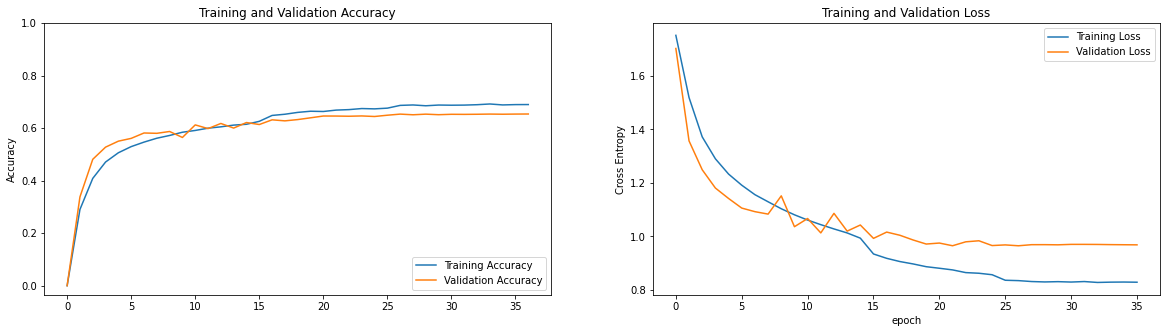

In [ ]:
# Plotting the accuracy and loss
plots(alexnet_history)

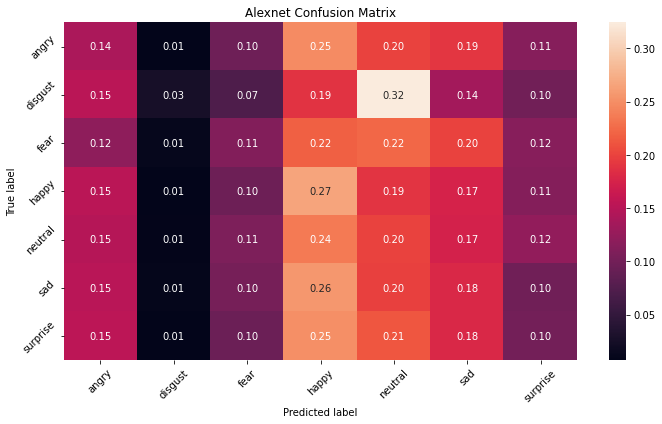

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=alexnet, model_name='alexnet')

In [ ]:
# Saving the model
alexnet.save('/content/drive/MyDrive/alexnet.h5')

<a name='6'></a>
# **Mobilenet**

In [ ]:
# categorical classification using MobileNetV2 
mobilenet = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                        Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                        # Using MobileNetV2
                        MobileNetV2(weights='imagenet', include_top=False, pooling = 'avg'),
                        # Using a fully connected layer with 128 units and relu activation
                        Dense(128, activation='relu'),
                        # Using a fully connected layer with 64 units and relu activation
                        Dense(64, activation='relu'),
                        # Using a prediction layer with seven neuron
                        Dense(7, activation='softmax')])

# Compiling the model
mobilenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
mobilenet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 128)               163968    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 7)                 455       
                                                                 
Total params: 2,430,693
Trainable params: 2,396,581
Non-t

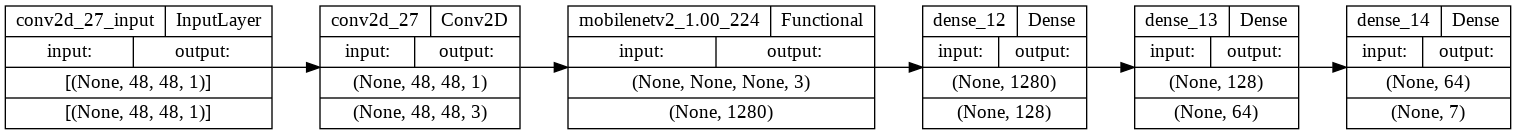

In [ ]:
# Plot model graph
plot_model(mobilenet, show_shapes=True, to_file='mobilenet.png', rankdir='LR')

In [ ]:
# Fitting the model
mobilenet_history = mobilenet.fit_generator(generator=train_data,
                                            steps_per_epoch=train_data.n//train_data.batch_size,
                                            epochs=50,
                                            validation_data = validation,
                                            validation_steps = validation.n//validation.batch_size,
                                            callbacks=callback_list('mobilenet')
                                            )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.8752 - accuracy: 0.2444WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 38s 73ms/step - loss: 1.8752 - accuracy: 0.2444 - val_loss: 1.9121 - val_accuracy: 0.2095 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.7053 - accuracy: 0.3191WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.7053 - accuracy: 0.3191 - val_loss: 1.8431 - val_accuracy: 0.2609 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.6456 - accuracy: 0.3513WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 73ms/step - loss: 1.6456 - accuracy: 0.3513 - val_loss: 1.7917 - val_accuracy: 0.2553 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.5889 - accuracy: 0.3807WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 68ms/step - loss: 1.5889 - accuracy: 0.3807 - val_loss: 1.7186 - val_accuracy: 0.2806 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - ETA: 0s - loss: 1.5401 - accuracy: 0.4015WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 1.5401 - accuracy: 0.4015 - val_loss: 1.6291 - val_accuracy: 0.3823 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - ETA: 0s - loss: 1.4989 - accuracy: 0.4217WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.4989 - accuracy: 0.4217 - val_loss: 1.5566 - val_accuracy: 0.4076 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============================] - ETA: 0s - loss: 1.4575 - accuracy: 0.4379WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 72ms/step - loss: 1.4575 - accuracy: 0.4379 - val_loss: 1.5127 - val_accuracy: 0.4256 - lr: 1.0000e-04
Epoch 8/50
448/448 [==============================] - ETA: 0s - loss: 1.4252 - accuracy: 0.4523WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 73ms/step - loss: 1.4252 - accuracy: 0.4523 - val_loss: 1.4430 - val_accuracy: 0.4439 - lr: 1.0000e-04
Epoch 9/50
448/448 [==============================] - ETA: 0s - loss: 1.3941 - accuracy: 0.4684WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 72ms/step - loss: 1.3941 - accuracy: 0.4684 - val_loss: 1.4129 - val_accuracy: 0.4554 - lr: 1.0000e-04
Epoch 10/50
448/448 [==============================] - ETA: 0s - loss: 1.3612 - accuracy: 0.4800WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 77ms/step - loss: 1.3612 - accuracy: 0.4800 - val_loss: 1.3379 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 11/50
448/448 [==============================] - ETA: 0s - loss: 1.3336 - accuracy: 0.4916WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 1.3336 - accuracy: 0.4916 - val_loss: 1.2885 - val_accuracy: 0.5085 - lr: 1.0000e-04
Epoch 12/50
448/448 [==============================] - ETA: 0s - loss: 1.3004 - accuracy: 0.5047WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.3004 - accuracy: 0.5047 - val_loss: 1.2940 - val_accuracy: 0.5073 - lr: 1.0000e-04
Epoch 13/50
448/448 [==============================] - ETA: 0s - loss: 1.2821 - accuracy: 0.5124WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 1.2821 - accuracy: 0.5124 - val_loss: 1.2603 - val_accuracy: 0.5195 - lr: 1.0000e-04
Epoch 14/50
448/448 [==============================] - ETA: 0s - loss: 1.2561 - accuracy: 0.5228WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 74ms/step - loss: 1.2561 - accuracy: 0.5228 - val_loss: 1.2564 - val_accuracy: 0.5257 - lr: 1.0000e-04
Epoch 15/50
448/448 [==============================] - ETA: 0s - loss: 1.2331 - accuracy: 0.5328WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.2331 - accuracy: 0.5328 - val_loss: 1.2588 - val_accuracy: 0.5264 - lr: 1.0000e-04
Epoch 16/50
448/448 [==============================] - ETA: 0s - loss: 1.2181 - accuracy: 0.5386WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.2181 - accuracy: 0.5386 - val_loss: 1.1989 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 17/50
448/448 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.5460WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.1944 - accuracy: 0.5460 - val_loss: 1.2055 - val_accuracy: 0.5530 - lr: 1.0000e-04
Epoch 18/50
448/448 [==============================] - ETA: 0s - loss: 1.1840 - accuracy: 0.5509WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.1840 - accuracy: 0.5509 - val_loss: 1.2074 - val_accuracy: 0.5516 - lr: 1.0000e-04
Epoch 19/50
448/448 [==============================] - ETA: 0s - loss: 1.1576 - accuracy: 0.5653WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.1576 - accuracy: 0.5653 - val_loss: 1.1677 - val_accuracy: 0.5604 - lr: 1.0000e-04
Epoch 20/50
448/448 [==============================] - ETA: 0s - loss: 1.1425 - accuracy: 0.5710WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.1425 - accuracy: 0.5710 - val_loss: 1.1647 - val_accuracy: 0.5622 - lr: 1.0000e-04
Epoch 21/50
448/448 [==============================] - ETA: 0s - loss: 1.1277 - accuracy: 0.5746WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 73ms/step - loss: 1.1277 - accuracy: 0.5746 - val_loss: 1.1536 - val_accuracy: 0.5654 - lr: 1.0000e-04
Epoch 22/50
448/448 [==============================] - ETA: 0s - loss: 1.1075 - accuracy: 0.5791WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.1075 - accuracy: 0.5791 - val_loss: 1.1579 - val_accuracy: 0.5646 - lr: 1.0000e-04
Epoch 23/50
448/448 [==============================] - ETA: 0s - loss: 1.0916 - accuracy: 0.5871WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 68ms/step - loss: 1.0916 - accuracy: 0.5871 - val_loss: 1.1091 - val_accuracy: 0.5759 - lr: 1.0000e-04
Epoch 24/50
448/448 [==============================] - ETA: 0s - loss: 1.0710 - accuracy: 0.5936WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.0710 - accuracy: 0.5936 - val_loss: 1.1385 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 25/50
448/448 [==============================] - ETA: 0s - loss: 1.0664 - accuracy: 0.5999WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 72ms/step - loss: 1.0664 - accuracy: 0.5999 - val_loss: 1.1210 - val_accuracy: 0.5755 - lr: 1.0000e-04
Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 1.0501 - accuracy: 0.5992WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.0501 - accuracy: 0.5992 - val_loss: 1.1090 - val_accuracy: 0.5776 - lr: 1.0000e-04
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 1.0377 - accuracy: 0.6105WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 1.0377 - accuracy: 0.6105 - val_loss: 1.0890 - val_accuracy: 0.5859 - lr: 1.0000e-04
Epoch 28/50
448/448 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.6131WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 1.0182 - accuracy: 0.6131 - val_loss: 1.1539 - val_accuracy: 0.5688 - lr: 1.0000e-04
Epoch 29/50
448/448 [==============================] - ETA: 0s - loss: 1.0081 - accuracy: 0.6182WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 72ms/step - loss: 1.0081 - accuracy: 0.6182 - val_loss: 1.0920 - val_accuracy: 0.5897 - lr: 1.0000e-04
Epoch 30/50
448/448 [==============================] - ETA: 0s - loss: 0.9928 - accuracy: 0.6239WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 68ms/step - loss: 0.9928 - accuracy: 0.6239 - val_loss: 1.0827 - val_accuracy: 0.5904 - lr: 1.0000e-04
Epoch 31/50
448/448 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.6264WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.9825 - accuracy: 0.6264 - val_loss: 1.1162 - val_accuracy: 0.5829 - lr: 1.0000e-04
Epoch 32/50
448/448 [==============================] - ETA: 0s - loss: 0.9649 - accuracy: 0.6373WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 0.9649 - accuracy: 0.6373 - val_loss: 1.0917 - val_accuracy: 0.5939 - lr: 1.0000e-04
Epoch 33/50
448/448 [==============================] - ETA: 0s - loss: 0.9536 - accuracy: 0.6399WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 74ms/step - loss: 0.9536 - accuracy: 0.6399 - val_loss: 1.0641 - val_accuracy: 0.6023 - lr: 1.0000e-04
Epoch 34/50
448/448 [==============================] - ETA: 0s - loss: 0.9354 - accuracy: 0.6487WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 0.9354 - accuracy: 0.6487 - val_loss: 1.0868 - val_accuracy: 0.5936 - lr: 1.0000e-04
Epoch 35/50
448/448 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.6472WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.9292 - accuracy: 0.6472 - val_loss: 1.1045 - val_accuracy: 0.5926 - lr: 1.0000e-04
Epoch 36/50
448/448 [==============================] - ETA: 0s - loss: 0.9073 - accuracy: 0.6556WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 36: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 31s 69ms/step - loss: 0.9073 - accuracy: 0.6556 - val_loss: 1.0761 - val_accuracy: 0.6048 - lr: 1.0000e-04
Epoch 37/50
448/448 [==============================] - ETA: 0s - loss: 0.8758 - accuracy: 0.6700WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 74ms/step - loss: 0.8758 - accuracy: 0.6700 - val_loss: 1.0581 - val_accuracy: 0.6045 - lr: 2.0000e-05
Epoch 38/50
448/448 [==============================] - ETA: 0s - loss: 0.8557 - accuracy: 0.6756WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 0.8557 - accuracy: 0.6756 - val_loss: 1.0452 - val_accuracy: 0.6140 - lr: 2.0000e-05
Epoch 39/50
448/448 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.6836WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.8412 - accuracy: 0.6836 - val_loss: 1.0486 - val_accuracy: 0.6110 - lr: 2.0000e-05
Epoch 40/50
448/448 [==============================] - ETA: 0s - loss: 0.8321 - accuracy: 0.6898WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 0.8321 - accuracy: 0.6898 - val_loss: 1.0379 - val_accuracy: 0.6157 - lr: 2.0000e-05
Epoch 41/50
448/448 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 0.6899WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 72ms/step - loss: 0.8285 - accuracy: 0.6899 - val_loss: 1.0388 - val_accuracy: 0.6113 - lr: 2.0000e-05
Epoch 42/50
448/448 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.6887WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.8207 - accuracy: 0.6887 - val_loss: 1.0379 - val_accuracy: 0.6161 - lr: 2.0000e-05
Epoch 43/50
448/448 [==============================] - ETA: 0s - loss: 0.8075 - accuracy: 0.6920WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 43: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 [==============================] - 31s 69ms/step - loss: 0.8075 - accuracy: 0.6920 - val_loss: 1.0437 - val_accuracy: 0.6161 - lr: 2.0000e-05
Epoch 44/50
448/448 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.6947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 69ms/step - loss: 0.8038 - accuracy: 0.6947 - val_loss: 1.0425 - val_accuracy: 0.6187 - lr: 4.0000e-06
Epoch 45/50
448/448 [==============================] - ETA: 0s - loss: 0.8052 - accuracy: 0.6982WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 33s 74ms/step - loss: 0.8052 - accuracy: 0.6982 - val_loss: 1.0442 - val_accuracy: 0.6172 - lr: 4.0000e-06
Epoch 46/50
448/448 [==============================] - ETA: 0s - loss: 0.7934 - accuracy: 0.7015WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 46: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
448/448 [==============================] - 32s 70ms/step - loss: 0.7934 - accuracy: 0.7015 - val_loss: 1.0424 - val_accuracy: 0.6175 - lr: 4.0000e-06
Epoch 47/50
448/448 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.6981WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 31s 70ms/step - loss: 0.7947 - accuracy: 0.6981 - val_loss: 1.0433 - val_accuracy: 0.6183 - lr: 8.0000e-07
Epoch 48/50
448/448 [==============================] - ETA: 0s - loss: 0.7996 - accuracy: 0.6980WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 70ms/step - loss: 0.7996 - accuracy: 0.6980 - val_loss: 1.0443 - val_accuracy: 0.6176 - lr: 8.0000e-07
Epoch 49/50
448/448 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.7018WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 49: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
448/448 [==============================] - 33s 74ms/step - loss: 0.7948 - accuracy: 0.7018 - val_loss: 1.0445 - val_accuracy: 0.6183 - lr: 8.0000e-07
Epoch 50/50
448/448 [==============================] - ETA: 0s - loss: 0.8015 - accuracy: 0.6989WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 32s 71ms/step - loss: 0.8015 - accuracy: 0.6989 - val_loss: 1.0455 - val_accuracy: 0.6177 - lr: 1.6000e-07


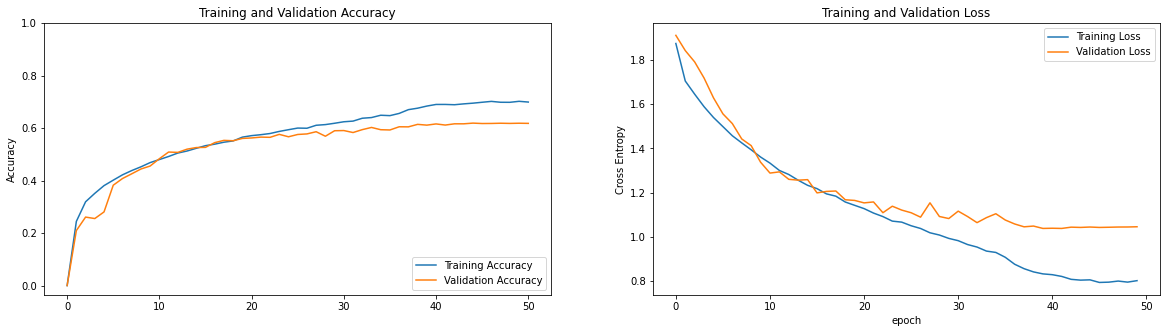

In [ ]:
# Plotting the accuracy and loss
plots(mobilenet_history)

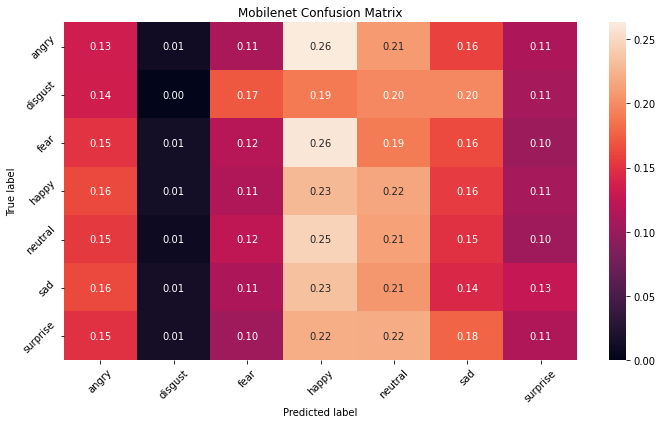

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=mobilenet, model_name='mobilenet')

In [ ]:
# Saving the model
mobilenet.save('/content/drive/MyDrive/mobilenet.h5')

<a name='7'></a>
# **VGG16**

In [ ]:
# Implementing VGG16 architecture
vgg16 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for vgg16
                    Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                    # Using VGG16 and Flattening the output
                    VGG16(include_top=False), Flatten(), BatchNormalization(),
                    # Using 2 fully connected layer with 4096 units and relu activation
                    Dense(4096, activation='relu'), BatchNormalization(),
                    Dense(4096, activation='relu'), BatchNormalization(),
                    # Using a prediction layer with seven neuron
                    Dense(7, activation='softmax')])

# Compiling the model
vgg16.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 4096)              2101248   
                                                                 
 batch_normalization_12 (Bat  (None, 4096)             

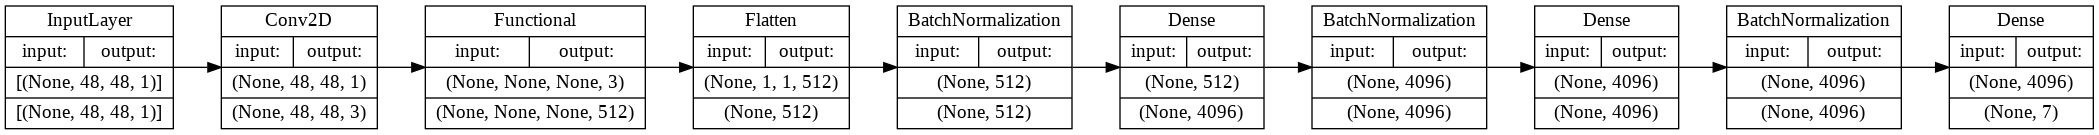

In [ ]:
# Plot model graph
plot_model(vgg16, show_shapes=True, to_file='vgg16.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
vgg16_history = vgg16.fit_generator(generator=train_data,
                                    steps_per_epoch=train_data.n//train_data.batch_size,
                                    epochs=50,
                                    validation_data = validation,
                                    validation_steps = validation.n//validation.batch_size,
                                    callbacks=callback_list('vgg16')
                                    )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.9027 - accuracy: 0.2907WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 38s 78ms/step - loss: 1.9027 - accuracy: 0.2907 - val_loss: 1.7970 - val_accuracy: 0.2916 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.5011 - accuracy: 0.4273WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 78ms/step - loss: 1.5011 - accuracy: 0.4273 - val_loss: 2.0285 - val_accuracy: 0.3461 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.3716 - accuracy: 0.4807WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 1.3716 - accuracy: 0.4807 - val_loss: 4.8779 - val_accuracy: 0.3170 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.3211 - accuracy: 0.5053WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 77ms/step - loss: 1.3211 - accuracy: 0.5053 - val_loss: 1.3097 - val_accuracy: 0.5163 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - ETA: 0s - loss: 1.2636 - accuracy: 0.5282WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 78ms/step - loss: 1.2636 - accuracy: 0.5282 - val_loss: 1.7624 - val_accuracy: 0.4145 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - ETA: 0s - loss: 1.2015 - accuracy: 0.5496WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 1.2015 - accuracy: 0.5496 - val_loss: 1.4591 - val_accuracy: 0.4626 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============================] - ETA: 0s - loss: 1.1674 - accuracy: 0.5629WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 1.1674 - accuracy: 0.5629 - val_loss: 1.2830 - val_accuracy: 0.5188 - lr: 1.0000e-04
Epoch 8/50
448/448 [==============================] - ETA: 0s - loss: 1.1374 - accuracy: 0.5714WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 75ms/step - loss: 1.1374 - accuracy: 0.5714 - val_loss: 1.2404 - val_accuracy: 0.5237 - lr: 1.0000e-04
Epoch 9/50
448/448 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.5861WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 36s 79ms/step - loss: 1.1089 - accuracy: 0.5861 - val_loss: 1.0704 - val_accuracy: 0.5943 - lr: 1.0000e-04
Epoch 10/50
448/448 [==============================] - ETA: 0s - loss: 1.0800 - accuracy: 0.5961WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 1.0800 - accuracy: 0.5961 - val_loss: 1.1490 - val_accuracy: 0.5647 - lr: 1.0000e-04
Epoch 11/50
448/448 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.6086WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 1.0550 - accuracy: 0.6086 - val_loss: 1.1261 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 12/50
448/448 [==============================] - ETA: 0s - loss: 1.0184 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 34s 75ms/step - loss: 1.0184 - accuracy: 0.6250 - val_loss: 1.1322 - val_accuracy: 0.5929 - lr: 1.0000e-04
Epoch 13/50
448/448 [==============================] - ETA: 0s - loss: 0.9307 - accuracy: 0.6557WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 78ms/step - loss: 0.9307 - accuracy: 0.6557 - val_loss: 0.9717 - val_accuracy: 0.6367 - lr: 2.0000e-05
Epoch 14/50
448/448 [==============================] - ETA: 0s - loss: 0.9015 - accuracy: 0.6632WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.9015 - accuracy: 0.6632 - val_loss: 0.9576 - val_accuracy: 0.6426 - lr: 2.0000e-05
Epoch 15/50
448/448 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.6724WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.8903 - accuracy: 0.6724 - val_loss: 0.9394 - val_accuracy: 0.6571 - lr: 2.0000e-05
Epoch 16/50
448/448 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.6757WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 78ms/step - loss: 0.8749 - accuracy: 0.6757 - val_loss: 0.9693 - val_accuracy: 0.6410 - lr: 2.0000e-05
Epoch 17/50
448/448 [==============================] - ETA: 0s - loss: 0.8647 - accuracy: 0.6809WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.8647 - accuracy: 0.6809 - val_loss: 0.9515 - val_accuracy: 0.6532 - lr: 2.0000e-05
Epoch 18/50
448/448 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.6844WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 18: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 [==============================] - 34s 75ms/step - loss: 0.8536 - accuracy: 0.6844 - val_loss: 0.9708 - val_accuracy: 0.6401 - lr: 2.0000e-05
Epoch 19/50
448/448 [==============================] - ETA: 0s - loss: 0.8185 - accuracy: 0.6951WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 75ms/step - loss: 0.8185 - accuracy: 0.6951 - val_loss: 0.9254 - val_accuracy: 0.6616 - lr: 4.0000e-06
Epoch 20/50
448/448 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.7001WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 78ms/step - loss: 0.8119 - accuracy: 0.7001 - val_loss: 0.9228 - val_accuracy: 0.6607 - lr: 4.0000e-06
Epoch 21/50
448/448 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.7008WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 75ms/step - loss: 0.8062 - accuracy: 0.7008 - val_loss: 0.9249 - val_accuracy: 0.6628 - lr: 4.0000e-06
Epoch 22/50
448/448 [==============================] - ETA: 0s - loss: 0.8025 - accuracy: 0.7018WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 75ms/step - loss: 0.8025 - accuracy: 0.7018 - val_loss: 0.9238 - val_accuracy: 0.6621 - lr: 4.0000e-06
Epoch 23/50
448/448 [==============================] - ETA: 0s - loss: 0.8001 - accuracy: 0.7032WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 23: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
448/448 [==============================] - 35s 79ms/step - loss: 0.8001 - accuracy: 0.7032 - val_loss: 0.9310 - val_accuracy: 0.6602 - lr: 4.0000e-06
Epoch 24/50
448/448 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.7993 - accuracy: 0.7031 - val_loss: 0.9233 - val_accuracy: 0.6618 - lr: 8.0000e-07
Epoch 25/50
448/448 [==============================] - ETA: 0s - loss: 0.7915 - accuracy: 0.7082WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.7915 - accuracy: 0.7082 - val_loss: 0.9207 - val_accuracy: 0.6645 - lr: 8.0000e-07
Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.7071WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.7951 - accuracy: 0.7071 - val_loss: 0.9248 - val_accuracy: 0.6617 - lr: 8.0000e-07
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 0.7876 - accuracy: 0.7093WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 36s 80ms/step - loss: 0.7876 - accuracy: 0.7093 - val_loss: 0.9243 - val_accuracy: 0.6629 - lr: 8.0000e-07
Epoch 28/50
448/448 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.7088WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 28: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
448/448 [==============================] - 34s 75ms/step - loss: 0.7846 - accuracy: 0.7088 - val_loss: 0.9252 - val_accuracy: 0.6624 - lr: 8.0000e-07
Epoch 29/50
448/448 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.7071WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 77ms/step - loss: 0.7886 - accuracy: 0.7071 - val_loss: 0.9239 - val_accuracy: 0.6632 - lr: 1.6000e-07
Epoch 30/50
448/448 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.7078WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 35s 78ms/step - loss: 0.7884 - accuracy: 0.7078 - val_loss: 0.9233 - val_accuracy: 0.6639 - lr: 1.6000e-07
Epoch 31/50
448/448 [==============================] - ETA: 0s - loss: 0.7862 - accuracy: 0.7119WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 31: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.
448/448 [==============================] - 34s 76ms/step - loss: 0.7862 - accuracy: 0.7119 - val_loss: 0.9220 - val_accuracy: 0.6645 - lr: 1.6000e-07
Epoch 32/50
448/448 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.7073WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.7882 - accuracy: 0.7073 - val_loss: 0.9244 - val_accuracy: 0.6639 - lr: 3.2000e-08
Epoch 33/50
448/448 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.7122WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 34s 76ms/step - loss: 0.7825 - accuracy: 0.7122 - val_loss: 0.9238 - val_accuracy: 0.6638 - lr: 3.2000e-08
Epoch 34/50
448/448 [==============================] - ETA: 0s - loss: 0.7860 - accuracy: 0.7104Restoring model weights from the end of the best epoch: 25.



Epoch 34: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.
448/448 [==============================] - 35s 78ms/step - loss: 0.7860 - accuracy: 0.7104 - val_loss: 0.9227 - val_accuracy: 0.6646 - lr: 3.2000e-08
Epoch 34: early stopping


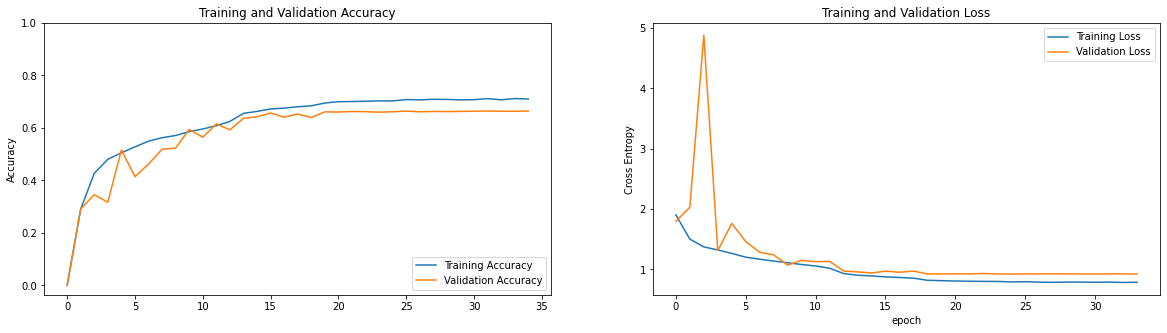

In [ ]:
# Plotting the accuracy and loss
plots(vgg16_history)

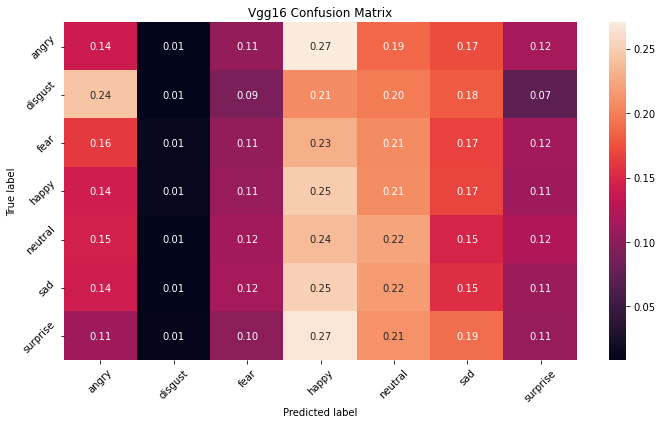

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=vgg16, model_name='vgg16')

In [ ]:
# Saving the model
vgg16.save('/content/drive/MyDrive/vgg16.h5')

<a name='8'></a>
# **VGG19**

In [ ]:
# categorical classification using VGG19 architecture
vgg19 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for vgg19
                    Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                    # Using VGG19 and Flattening the output
                    VGG19(include_top=False), Flatten(), BatchNormalization(),
                    # Using 2 fully connected layer with 4096 units and relu activation
                    Dense(4096, activation='relu'), BatchNormalization(),
                    Dense(4096, activation='relu'), BatchNormalization(),
                    # Using a prediction layer with seven neuron
                    Dense(7, activation='softmax')])

# Compiling the model
vgg19.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
vgg19.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_14 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 4096)              2101248   
                                                                 
 batch_normalization_15 (Bat  (None, 4096)             

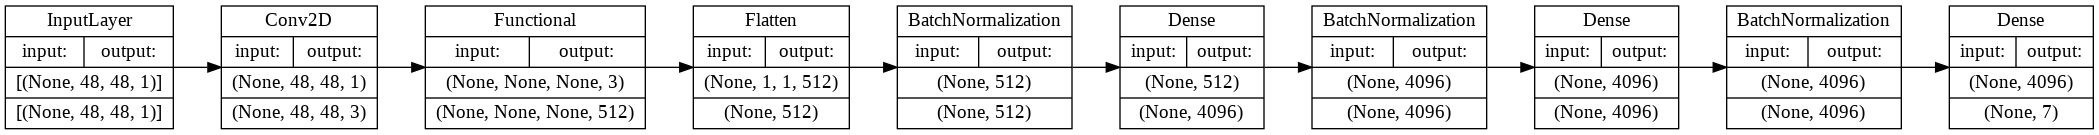

In [ ]:
# Plot model graph
plot_model(vgg19, show_shapes=True, to_file='vgg19.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
vgg19_history = vgg19.fit_generator(generator=train_data,
                                    steps_per_epoch=train_data.n//train_data.batch_size,
                                    epochs=50,
                                    validation_data = validation,
                                    validation_steps = validation.n//validation.batch_size,
                                    callbacks=callback_list('vgg19')
                                    )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.9830 - accuracy: 0.2317WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 42s 90ms/step - loss: 1.9830 - accuracy: 0.2317 - val_loss: 3.7342 - val_accuracy: 0.1681 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.6660 - accuracy: 0.3462WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 90ms/step - loss: 1.6660 - accuracy: 0.3462 - val_loss: 3.1707 - val_accuracy: 0.1987 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.4957 - accuracy: 0.4233WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 1.4957 - accuracy: 0.4233 - val_loss: 1.7064 - val_accuracy: 0.4321 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.3921 - accuracy: 0.4707WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 1.3921 - accuracy: 0.4707 - val_loss: 1.6421 - val_accuracy: 0.3841 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - ETA: 0s - loss: 1.3354 - accuracy: 0.4933WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 90ms/step - loss: 1.3354 - accuracy: 0.4933 - val_loss: 1.8372 - val_accuracy: 0.3813 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - ETA: 0s - loss: 1.2722 - accuracy: 0.5176WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 1.2722 - accuracy: 0.5176 - val_loss: 1.2062 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============================] - ETA: 0s - loss: 1.2286 - accuracy: 0.5381WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 88ms/step - loss: 1.2286 - accuracy: 0.5381 - val_loss: 1.3049 - val_accuracy: 0.5088 - lr: 1.0000e-04
Epoch 8/50
448/448 [==============================] - ETA: 0s - loss: 1.2152 - accuracy: 0.5446WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 1.2152 - accuracy: 0.5446 - val_loss: 1.4650 - val_accuracy: 0.4587 - lr: 1.0000e-04
Epoch 9/50
448/448 [==============================] - ETA: 0s - loss: 1.1700 - accuracy: 0.5630WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 41s 91ms/step - loss: 1.1700 - accuracy: 0.5630 - val_loss: 1.3554 - val_accuracy: 0.4967 - lr: 1.0000e-04
Epoch 10/50
448/448 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.6068WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 1.0540 - accuracy: 0.6068 - val_loss: 1.0178 - val_accuracy: 0.6164 - lr: 2.0000e-05
Epoch 11/50
448/448 [==============================] - ETA: 0s - loss: 1.0277 - accuracy: 0.6175WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 88ms/step - loss: 1.0277 - accuracy: 0.6175 - val_loss: 1.0390 - val_accuracy: 0.6157 - lr: 2.0000e-05
Epoch 12/50
448/448 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.6249WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 1.0079 - accuracy: 0.6249 - val_loss: 1.0148 - val_accuracy: 0.6236 - lr: 2.0000e-05
Epoch 13/50
448/448 [==============================] - ETA: 0s - loss: 1.0029 - accuracy: 0.6253WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 88ms/step - loss: 1.0029 - accuracy: 0.6253 - val_loss: 1.0263 - val_accuracy: 0.6081 - lr: 2.0000e-05
Epoch 14/50
448/448 [==============================] - ETA: 0s - loss: 0.9908 - accuracy: 0.6319WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 88ms/step - loss: 0.9908 - accuracy: 0.6319 - val_loss: 1.0268 - val_accuracy: 0.6053 - lr: 2.0000e-05
Epoch 15/50
448/448 [==============================] - ETA: 0s - loss: 0.9829 - accuracy: 0.6318WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 90ms/step - loss: 0.9829 - accuracy: 0.6318 - val_loss: 0.9928 - val_accuracy: 0.6254 - lr: 2.0000e-05
Epoch 16/50
448/448 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.6384WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.9701 - accuracy: 0.6384 - val_loss: 1.0363 - val_accuracy: 0.6133 - lr: 2.0000e-05
Epoch 17/50
448/448 [==============================] - ETA: 0s - loss: 0.9636 - accuracy: 0.6374WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.9636 - accuracy: 0.6374 - val_loss: 0.9746 - val_accuracy: 0.6342 - lr: 2.0000e-05
Epoch 18/50
448/448 [==============================] - ETA: 0s - loss: 0.9536 - accuracy: 0.6441WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 88ms/step - loss: 0.9536 - accuracy: 0.6441 - val_loss: 0.9785 - val_accuracy: 0.6313 - lr: 2.0000e-05
Epoch 19/50
448/448 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.6471WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 0.9389 - accuracy: 0.6471 - val_loss: 0.9845 - val_accuracy: 0.6324 - lr: 2.0000e-05
Epoch 20/50
448/448 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.6534WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 20: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 [==============================] - 40s 89ms/step - loss: 0.9348 - accuracy: 0.6534 - val_loss: 1.0261 - val_accuracy: 0.6087 - lr: 2.0000e-05
Epoch 21/50
448/448 [==============================] - ETA: 0s - loss: 0.8999 - accuracy: 0.6673WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8999 - accuracy: 0.6673 - val_loss: 0.9517 - val_accuracy: 0.6427 - lr: 4.0000e-06
Epoch 22/50
448/448 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.6699WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 0.8879 - accuracy: 0.6699 - val_loss: 0.9434 - val_accuracy: 0.6438 - lr: 4.0000e-06
Epoch 23/50
448/448 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.6723WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8861 - accuracy: 0.6723 - val_loss: 0.9362 - val_accuracy: 0.6484 - lr: 4.0000e-06
Epoch 24/50
448/448 [==============================] - ETA: 0s - loss: 0.8821 - accuracy: 0.6724WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8821 - accuracy: 0.6724 - val_loss: 0.9604 - val_accuracy: 0.6367 - lr: 4.0000e-06
Epoch 25/50
448/448 [==============================] - ETA: 0s - loss: 0.8777 - accuracy: 0.6736WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8777 - accuracy: 0.6736 - val_loss: 0.9361 - val_accuracy: 0.6473 - lr: 4.0000e-06
Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 0.8754 - accuracy: 0.6735WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 26: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
448/448 [==============================] - 41s 91ms/step - loss: 0.8754 - accuracy: 0.6735 - val_loss: 0.9426 - val_accuracy: 0.6454 - lr: 4.0000e-06
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.6768WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8690 - accuracy: 0.6768 - val_loss: 0.9292 - val_accuracy: 0.6529 - lr: 8.0000e-07
Epoch 28/50
448/448 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.6792WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8636 - accuracy: 0.6792 - val_loss: 0.9303 - val_accuracy: 0.6503 - lr: 8.0000e-07
Epoch 29/50
448/448 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.6816WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 0.8610 - accuracy: 0.6816 - val_loss: 0.9313 - val_accuracy: 0.6523 - lr: 8.0000e-07
Epoch 30/50
448/448 [==============================] - ETA: 0s - loss: 0.8637 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8637 - accuracy: 0.6771 - val_loss: 0.9290 - val_accuracy: 0.6512 - lr: 8.0000e-07
Epoch 31/50
448/448 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.6808WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8585 - accuracy: 0.6808 - val_loss: 0.9284 - val_accuracy: 0.6526 - lr: 8.0000e-07
Epoch 32/50
448/448 [==============================] - ETA: 0s - loss: 0.8618 - accuracy: 0.6787WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 0.8618 - accuracy: 0.6787 - val_loss: 0.9273 - val_accuracy: 0.6542 - lr: 8.0000e-07
Epoch 33/50
448/448 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.6799WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8585 - accuracy: 0.6799 - val_loss: 0.9292 - val_accuracy: 0.6535 - lr: 8.0000e-07
Epoch 34/50
448/448 [==============================] - ETA: 0s - loss: 0.8597 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8597 - accuracy: 0.6812 - val_loss: 0.9280 - val_accuracy: 0.6529 - lr: 8.0000e-07
Epoch 35/50
448/448 [==============================] - ETA: 0s - loss: 0.8614 - accuracy: 0.6781WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 35: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
448/448 [==============================] - 40s 89ms/step - loss: 0.8614 - accuracy: 0.6781 - val_loss: 0.9293 - val_accuracy: 0.6536 - lr: 8.0000e-07
Epoch 36/50
448/448 [==============================] - ETA: 0s - loss: 0.8560 - accuracy: 0.6808WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 0.8560 - accuracy: 0.6808 - val_loss: 0.9280 - val_accuracy: 0.6543 - lr: 1.6000e-07
Epoch 37/50
448/448 [==============================] - ETA: 0s - loss: 0.8560 - accuracy: 0.6798WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 42s 94ms/step - loss: 0.8560 - accuracy: 0.6798 - val_loss: 0.9298 - val_accuracy: 0.6542 - lr: 1.6000e-07
Epoch 38/50
448/448 [==============================] - ETA: 0s - loss: 0.8564 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 38: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.
448/448 [==============================] - 40s 89ms/step - loss: 0.8564 - accuracy: 0.6812 - val_loss: 0.9292 - val_accuracy: 0.6526 - lr: 1.6000e-07
Epoch 39/50
448/448 [==============================] - ETA: 0s - loss: 0.8594 - accuracy: 0.6800WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 43s 96ms/step - loss: 0.8594 - accuracy: 0.6800 - val_loss: 0.9271 - val_accuracy: 0.6537 - lr: 3.2000e-08
Epoch 40/50
448/448 [==============================] - ETA: 0s - loss: 0.8563 - accuracy: 0.6789WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 90ms/step - loss: 0.8563 - accuracy: 0.6789 - val_loss: 0.9283 - val_accuracy: 0.6533 - lr: 3.2000e-08
Epoch 41/50
448/448 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.6806WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8608 - accuracy: 0.6806 - val_loss: 0.9293 - val_accuracy: 0.6533 - lr: 3.2000e-08
Epoch 42/50
448/448 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.6836WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 42: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.
448/448 [==============================] - 41s 91ms/step - loss: 0.8535 - accuracy: 0.6836 - val_loss: 0.9287 - val_accuracy: 0.6535 - lr: 3.2000e-08
Epoch 43/50
448/448 [==============================] - ETA: 0s - loss: 0.8550 - accuracy: 0.6805WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 90ms/step - loss: 0.8550 - accuracy: 0.6805 - val_loss: 0.9283 - val_accuracy: 0.6532 - lr: 6.4000e-09
Epoch 44/50
448/448 [==============================] - ETA: 0s - loss: 0.8518 - accuracy: 0.6850WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 0.8518 - accuracy: 0.6850 - val_loss: 0.9293 - val_accuracy: 0.6525 - lr: 6.4000e-09
Epoch 45/50
448/448 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.6826WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 45: ReduceLROnPlateau reducing learning rate to 1.279999928271991e-09.
448/448 [==============================] - 40s 89ms/step - loss: 0.8514 - accuracy: 0.6826 - val_loss: 0.9282 - val_accuracy: 0.6530 - lr: 6.4000e-09
Epoch 46/50
448/448 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.6821WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 40s 89ms/step - loss: 0.8515 - accuracy: 0.6821 - val_loss: 0.9290 - val_accuracy: 0.6537 - lr: 1.2800e-09
Epoch 47/50
448/448 [==============================] - ETA: 0s - loss: 0.8550 - accuracy: 0.6810WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 41s 91ms/step - loss: 0.8550 - accuracy: 0.6810 - val_loss: 0.9284 - val_accuracy: 0.6535 - lr: 1.2800e-09
Epoch 48/50
448/448 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.6821Restoring model weights from the end of the best epoch: 39.



Epoch 48: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.
448/448 [==============================] - 40s 89ms/step - loss: 0.8605 - accuracy: 0.6821 - val_loss: 0.9286 - val_accuracy: 0.6540 - lr: 1.2800e-09
Epoch 48: early stopping


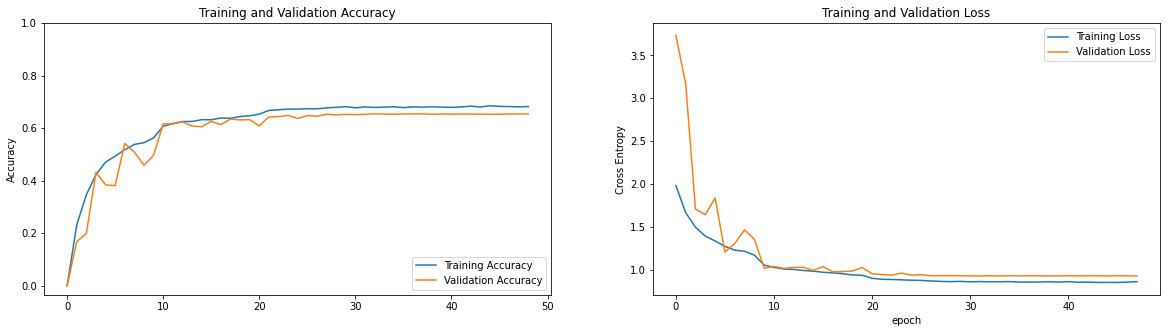

In [ ]:
# Plotting the accuracy and loss
plots(vgg19_history)

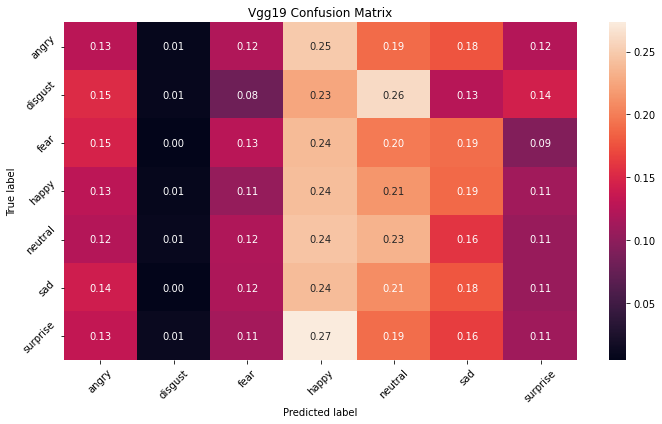

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=vgg19, model_name='vgg19')

In [ ]:
# Saving the model
vgg19.save('/content/drive/MyDrive/vgg19.h5')

<a name='9'></a>
# **Custom Model**

In [ ]:
# Defining a custom CNN architecture using keras sequential API
custom_model = Sequential([# First CNN layer
                           Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(48, 48, 1)),
                           # Second CNN layer
                           Conv2D(filters=64, kernel_size=5, activation='relu'),
                           MaxPool2D(pool_size = 2),
                           # Third CNN layer and flattening te outputs
                           Conv2D(filters=128, kernel_size=3, activation='relu'),
                           MaxPool2D(pool_size = 2), Flatten(),
                           # Adding 2 fully connected layers with dropout
                           Dense(1024, activation='relu'), Dropout(0.5),
                           Dense(512, activation='relu'), Dropout(0.5),
                           # using a prediction layer with seven neuron 
                           Dense(7, activation='softmax')])

# Compiling the model
custom_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
custom_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 44, 44, 32)        832       
                                                                 
 conv2d_31 (Conv2D)          (None, 40, 40, 64)        51264     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 18, 18, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 9, 9, 128)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 10368)            

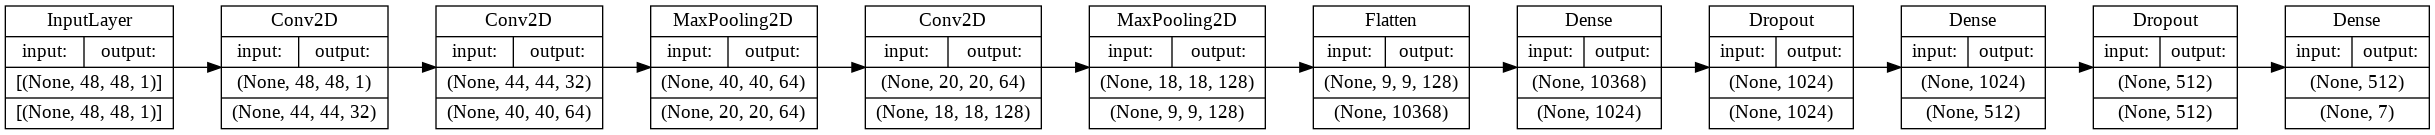

In [ ]:
# Plot model graph
plot_model(custom_model, show_shapes=True, to_file='custom_model.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
custom_history = custom_model.fit_generator(generator=train_data,
                                            steps_per_epoch=train_data.n//train_data.batch_size,
                                            epochs=50,
                                            validation_data = validation,
                                            validation_steps = validation.n//validation.batch_size,
                                            callbacks=callback_list('custom_model')
                                            )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.8040 - accuracy: 0.2519WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 29s 63ms/step - loss: 1.8040 - accuracy: 0.2519 - val_loss: 1.6990 - val_accuracy: 0.3248 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.7310 - accuracy: 0.2970WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.7310 - accuracy: 0.2970 - val_loss: 1.5992 - val_accuracy: 0.3772 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.6794 - accuracy: 0.3318WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 26s 59ms/step - loss: 1.6794 - accuracy: 0.3318 - val_loss: 1.5572 - val_accuracy: 0.4056 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.6290 - accuracy: 0.3564WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.6290 - accuracy: 0.3564 - val_loss: 1.4741 - val_accuracy: 0.4424 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - ETA: 0s - loss: 1.5805 - accuracy: 0.3840WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 26s 58ms/step - loss: 1.5805 - accuracy: 0.3840 - val_loss: 1.4339 - val_accuracy: 0.4554 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - ETA: 0s - loss: 1.5334 - accuracy: 0.4064WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 26s 58ms/step - loss: 1.5334 - accuracy: 0.4064 - val_loss: 1.3727 - val_accuracy: 0.4694 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============================] - ETA: 0s - loss: 1.4925 - accuracy: 0.4246WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 26s 59ms/step - loss: 1.4925 - accuracy: 0.4246 - val_loss: 1.3320 - val_accuracy: 0.4876 - lr: 1.0000e-04
Epoch 8/50
448/448 [==============================] - ETA: 0s - loss: 1.4580 - accuracy: 0.4383WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.4580 - accuracy: 0.4383 - val_loss: 1.3005 - val_accuracy: 0.5060 - lr: 1.0000e-04
Epoch 9/50
448/448 [==============================] - ETA: 0s - loss: 1.4196 - accuracy: 0.4573WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.4196 - accuracy: 0.4573 - val_loss: 1.2832 - val_accuracy: 0.5162 - lr: 1.0000e-04
Epoch 10/50
448/448 [==============================] - ETA: 0s - loss: 1.4003 - accuracy: 0.4625WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 26s 59ms/step - loss: 1.4003 - accuracy: 0.4625 - val_loss: 1.2501 - val_accuracy: 0.5241 - lr: 1.0000e-04
Epoch 11/50
448/448 [==============================] - ETA: 0s - loss: 1.3735 - accuracy: 0.4748WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 59ms/step - loss: 1.3735 - accuracy: 0.4748 - val_loss: 1.2229 - val_accuracy: 0.5374 - lr: 1.0000e-04
Epoch 12/50
448/448 [==============================] - ETA: 0s - loss: 1.3500 - accuracy: 0.4854WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.3500 - accuracy: 0.4854 - val_loss: 1.2228 - val_accuracy: 0.5307 - lr: 1.0000e-04
Epoch 13/50
448/448 [==============================] - ETA: 0s - loss: 1.3331 - accuracy: 0.4916WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 26s 58ms/step - loss: 1.3331 - accuracy: 0.4916 - val_loss: 1.2065 - val_accuracy: 0.5439 - lr: 1.0000e-04
Epoch 14/50
448/448 [==============================] - ETA: 0s - loss: 1.3207 - accuracy: 0.5002WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.3207 - accuracy: 0.5002 - val_loss: 1.1870 - val_accuracy: 0.5501 - lr: 1.0000e-04
Epoch 15/50
448/448 [==============================] - ETA: 0s - loss: 1.3055 - accuracy: 0.5046WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 26s 59ms/step - loss: 1.3055 - accuracy: 0.5046 - val_loss: 1.1733 - val_accuracy: 0.5537 - lr: 1.0000e-04
Epoch 16/50
448/448 [==============================] - ETA: 0s - loss: 1.2866 - accuracy: 0.5108WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.2866 - accuracy: 0.5108 - val_loss: 1.1557 - val_accuracy: 0.5562 - lr: 1.0000e-04
Epoch 17/50
448/448 [==============================] - ETA: 0s - loss: 1.2719 - accuracy: 0.5134WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.2719 - accuracy: 0.5134 - val_loss: 1.1392 - val_accuracy: 0.5650 - lr: 1.0000e-04
Epoch 18/50
448/448 [==============================] - ETA: 0s - loss: 1.2587 - accuracy: 0.5221WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.2587 - accuracy: 0.5221 - val_loss: 1.1574 - val_accuracy: 0.5589 - lr: 1.0000e-04
Epoch 19/50
448/448 [==============================] - ETA: 0s - loss: 1.2485 - accuracy: 0.5307WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.2485 - accuracy: 0.5307 - val_loss: 1.1440 - val_accuracy: 0.5564 - lr: 1.0000e-04
Epoch 20/50
448/448 [==============================] - ETA: 0s - loss: 1.2443 - accuracy: 0.5275WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 20: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 27s 61ms/step - loss: 1.2443 - accuracy: 0.5275 - val_loss: 1.1431 - val_accuracy: 0.5618 - lr: 1.0000e-04
Epoch 21/50
448/448 [==============================] - ETA: 0s - loss: 1.2102 - accuracy: 0.5396WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.2102 - accuracy: 0.5396 - val_loss: 1.1060 - val_accuracy: 0.5760 - lr: 2.0000e-05
Epoch 22/50
448/448 [==============================] - ETA: 0s - loss: 1.2053 - accuracy: 0.5446WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.2053 - accuracy: 0.5446 - val_loss: 1.1055 - val_accuracy: 0.5727 - lr: 2.0000e-05
Epoch 23/50
448/448 [==============================] - ETA: 0s - loss: 1.2014 - accuracy: 0.5447WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.2014 - accuracy: 0.5447 - val_loss: 1.1032 - val_accuracy: 0.5745 - lr: 2.0000e-05
Epoch 24/50
448/448 [==============================] - ETA: 0s - loss: 1.2057 - accuracy: 0.5438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.2057 - accuracy: 0.5438 - val_loss: 1.1027 - val_accuracy: 0.5769 - lr: 2.0000e-05
Epoch 25/50
448/448 [==============================] - ETA: 0s - loss: 1.1951 - accuracy: 0.5462WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.1951 - accuracy: 0.5462 - val_loss: 1.0947 - val_accuracy: 0.5798 - lr: 2.0000e-05
Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 1.1983 - accuracy: 0.5460WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 28s 62ms/step - loss: 1.1983 - accuracy: 0.5460 - val_loss: 1.0958 - val_accuracy: 0.5815 - lr: 2.0000e-05
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 1.1899 - accuracy: 0.5482WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 29s 64ms/step - loss: 1.1899 - accuracy: 0.5482 - val_loss: 1.0996 - val_accuracy: 0.5808 - lr: 2.0000e-05
Epoch 28/50
448/448 [==============================] - ETA: 0s - loss: 1.1911 - accuracy: 0.5475WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1911 - accuracy: 0.5475 - val_loss: 1.0879 - val_accuracy: 0.5824 - lr: 2.0000e-05
Epoch 29/50
448/448 [==============================] - ETA: 0s - loss: 1.1874 - accuracy: 0.5504WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1874 - accuracy: 0.5504 - val_loss: 1.0824 - val_accuracy: 0.5840 - lr: 2.0000e-05
Epoch 30/50
448/448 [==============================] - ETA: 0s - loss: 1.1855 - accuracy: 0.5504WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.1855 - accuracy: 0.5504 - val_loss: 1.0808 - val_accuracy: 0.5837 - lr: 2.0000e-05
Epoch 31/50
448/448 [==============================] - ETA: 0s - loss: 1.1815 - accuracy: 0.5530WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 29s 65ms/step - loss: 1.1815 - accuracy: 0.5530 - val_loss: 1.0862 - val_accuracy: 0.5840 - lr: 2.0000e-05
Epoch 32/50
448/448 [==============================] - ETA: 0s - loss: 1.1763 - accuracy: 0.5549WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.1763 - accuracy: 0.5549 - val_loss: 1.0772 - val_accuracy: 0.5904 - lr: 2.0000e-05
Epoch 33/50
448/448 [==============================] - ETA: 0s - loss: 1.1791 - accuracy: 0.5507WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1791 - accuracy: 0.5507 - val_loss: 1.0784 - val_accuracy: 0.5861 - lr: 2.0000e-05
Epoch 34/50
448/448 [==============================] - ETA: 0s - loss: 1.1725 - accuracy: 0.5550WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.1725 - accuracy: 0.5550 - val_loss: 1.0796 - val_accuracy: 0.5843 - lr: 2.0000e-05
Epoch 35/50
448/448 [==============================] - ETA: 0s - loss: 1.1743 - accuracy: 0.5565WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 29s 64ms/step - loss: 1.1743 - accuracy: 0.5565 - val_loss: 1.0760 - val_accuracy: 0.5882 - lr: 2.0000e-05
Epoch 36/50
448/448 [==============================] - ETA: 0s - loss: 1.1701 - accuracy: 0.5585WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1701 - accuracy: 0.5585 - val_loss: 1.0695 - val_accuracy: 0.5893 - lr: 2.0000e-05
Epoch 37/50
448/448 [==============================] - ETA: 0s - loss: 1.1678 - accuracy: 0.5574WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.1678 - accuracy: 0.5574 - val_loss: 1.0740 - val_accuracy: 0.5872 - lr: 2.0000e-05
Epoch 38/50
448/448 [==============================] - ETA: 0s - loss: 1.1689 - accuracy: 0.5565WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1689 - accuracy: 0.5565 - val_loss: 1.0702 - val_accuracy: 0.5933 - lr: 2.0000e-05
Epoch 39/50
448/448 [==============================] - ETA: 0s - loss: 1.1684 - accuracy: 0.5559WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 28s 62ms/step - loss: 1.1684 - accuracy: 0.5559 - val_loss: 1.0664 - val_accuracy: 0.5922 - lr: 2.0000e-05
Epoch 40/50
448/448 [==============================] - ETA: 0s - loss: 1.1620 - accuracy: 0.5606WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.1620 - accuracy: 0.5606 - val_loss: 1.0656 - val_accuracy: 0.5901 - lr: 2.0000e-05
Epoch 41/50
448/448 [==============================] - ETA: 0s - loss: 1.1565 - accuracy: 0.5637WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 28s 62ms/step - loss: 1.1565 - accuracy: 0.5637 - val_loss: 1.0664 - val_accuracy: 0.5938 - lr: 2.0000e-05
Epoch 42/50
448/448 [==============================] - ETA: 0s - loss: 1.1533 - accuracy: 0.5617WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 60ms/step - loss: 1.1533 - accuracy: 0.5617 - val_loss: 1.0643 - val_accuracy: 0.5929 - lr: 2.0000e-05
Epoch 43/50
448/448 [==============================] - ETA: 0s - loss: 1.1564 - accuracy: 0.5653WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 29s 64ms/step - loss: 1.1564 - accuracy: 0.5653 - val_loss: 1.0617 - val_accuracy: 0.5960 - lr: 2.0000e-05
Epoch 44/50
448/448 [==============================] - ETA: 0s - loss: 1.1553 - accuracy: 0.5631WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 28s 61ms/step - loss: 1.1553 - accuracy: 0.5631 - val_loss: 1.0655 - val_accuracy: 0.5940 - lr: 2.0000e-05
Epoch 45/50
448/448 [==============================] - ETA: 0s - loss: 1.1517 - accuracy: 0.5638WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1517 - accuracy: 0.5638 - val_loss: 1.0678 - val_accuracy: 0.5933 - lr: 2.0000e-05
Epoch 46/50
448/448 [==============================] - ETA: 0s - loss: 1.1498 - accuracy: 0.5641WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 28s 61ms/step - loss: 1.1498 - accuracy: 0.5641 - val_loss: 1.0609 - val_accuracy: 0.5949 - lr: 2.0000e-05
Epoch 47/50
448/448 [==============================] - ETA: 0s - loss: 1.1487 - accuracy: 0.5643WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 28s 63ms/step - loss: 1.1487 - accuracy: 0.5643 - val_loss: 1.0651 - val_accuracy: 0.5928 - lr: 2.0000e-05
Epoch 48/50
448/448 [==============================] - ETA: 0s - loss: 1.1418 - accuracy: 0.5678WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1418 - accuracy: 0.5678 - val_loss: 1.0596 - val_accuracy: 0.5946 - lr: 2.0000e-05
Epoch 49/50
448/448 [==============================] - ETA: 0s - loss: 1.1407 - accuracy: 0.5697WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1407 - accuracy: 0.5697 - val_loss: 1.0569 - val_accuracy: 0.5939 - lr: 2.0000e-05
Epoch 50/50
448/448 [==============================] - ETA: 0s - loss: 1.1460 - accuracy: 0.5666WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 27s 61ms/step - loss: 1.1460 - accuracy: 0.5666 - val_loss: 1.0505 - val_accuracy: 0.5984 - lr: 2.0000e-05


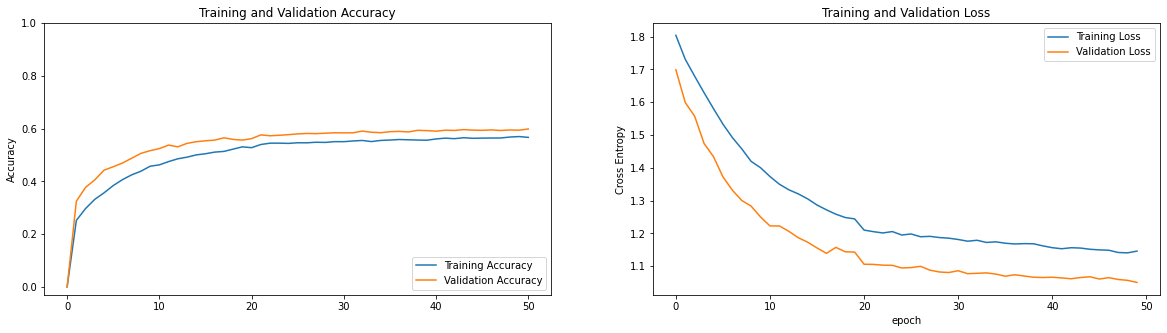

In [ ]:
# Plotting the accuracy and loss
plots(custom_history)

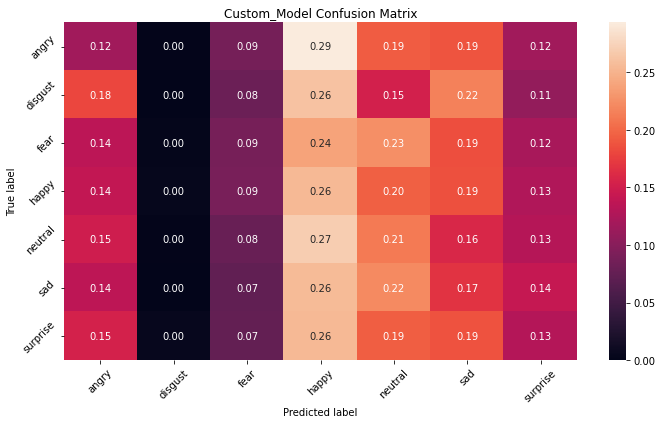

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=custom_model, model_name='custom_model')

In [ ]:
# Saving the model
custom_model.save('/content/drive/MyDrive/custom_model.h5')

<a name='10'></a>
# **Basic Inception Model**

In [ ]:
# Defining a function for basic inception model
def basic_inception(input_shape=(48,48,1), F1=32, F3_in=32, F3_out=64, F5_in=8, F5_out=16, Mp_out=16):
    ''' Defining a basic inception model for categorical classification out of the three inception blocks
    Arguments:
        input_shape -- Image width,height and channels
        F1 -- Number of 1x1 filters
        F3_in -- Number of 1x1 filters to place before the 3x3 filter
        F3_out -- Number of 3x3 filters
        F5_in -- Number of 1x1 filters to place before the 5x5 filter
        F5_out -- Number of 5x5 filters
        Mp_out -- Number of 1x1 filters to place after maxpooling
    Returns:
        basic inception model with 3 inception blocks, 2 FC layers and one prediction layer wit 7 neurons.
    '''
    # Define input
    inputs = Input(shape=input_shape)

    # Creating a basic inception block
    def inception_block(input_layer, f1=F1, f3_in=F3_in, f3_out=F3_out, f5_in=F5_in, f5_out=F5_out, mp_out=Mp_out):
        # 1x1 Convolution
        conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(input_layer)
        # 3x3 Convolution
        conv3 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(input_layer)
        conv3 = Conv2D(f3_out, (3,3), padding='same', activation='relu')(conv3)
        # 5x5 Convolution
        conv5 = Conv2D(f5_in, (1,1), padding='same', activation='relu')(input_layer)
        conv5 = Conv2D(f5_out, (5,5), padding='same', activation='relu')(conv5)
        # 3x3 Max Pooling
        pool = MaxPool2D((3,3), strides=(1,1), padding='same')(input_layer)
        pool = Conv2D(mp_out, (1,1), padding='same', activation='relu')(pool)
        # Concatenate
        layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
        return layer_out

    # First inception block
    iblock1 = inception_block(inputs)
    iblock1 = BatchNormalization()(iblock1)
    # Second inception block
    iblock2 = inception_block(iblock1)
    iblock2 = BatchNormalization()(iblock2)
    # Third inception block
    iblock3 = inception_block(iblock2)
    
    # Flattening for output
    flat = Flatten()(iblock3)
    flat = BatchNormalization()(flat)
    
    # Adding 2 FC layers and the prediction layer
    dense1 = Dense(256, activation='relu')(flat)
    dense1 = BatchNormalization()(dense1)
    dense2 = Dense(128, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    outputs = Dense(7, activation='softmax')(dense2)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# Defining the model
inception = basic_inception()

# Compiling the model
inception.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_34 (Conv2D)             (None, 48, 48, 32)   64          ['input_5[0][0]']                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 48, 48, 8)    16          ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 48, 48, 1)   0           ['input_5[0][0]']                
 )                                                                                          

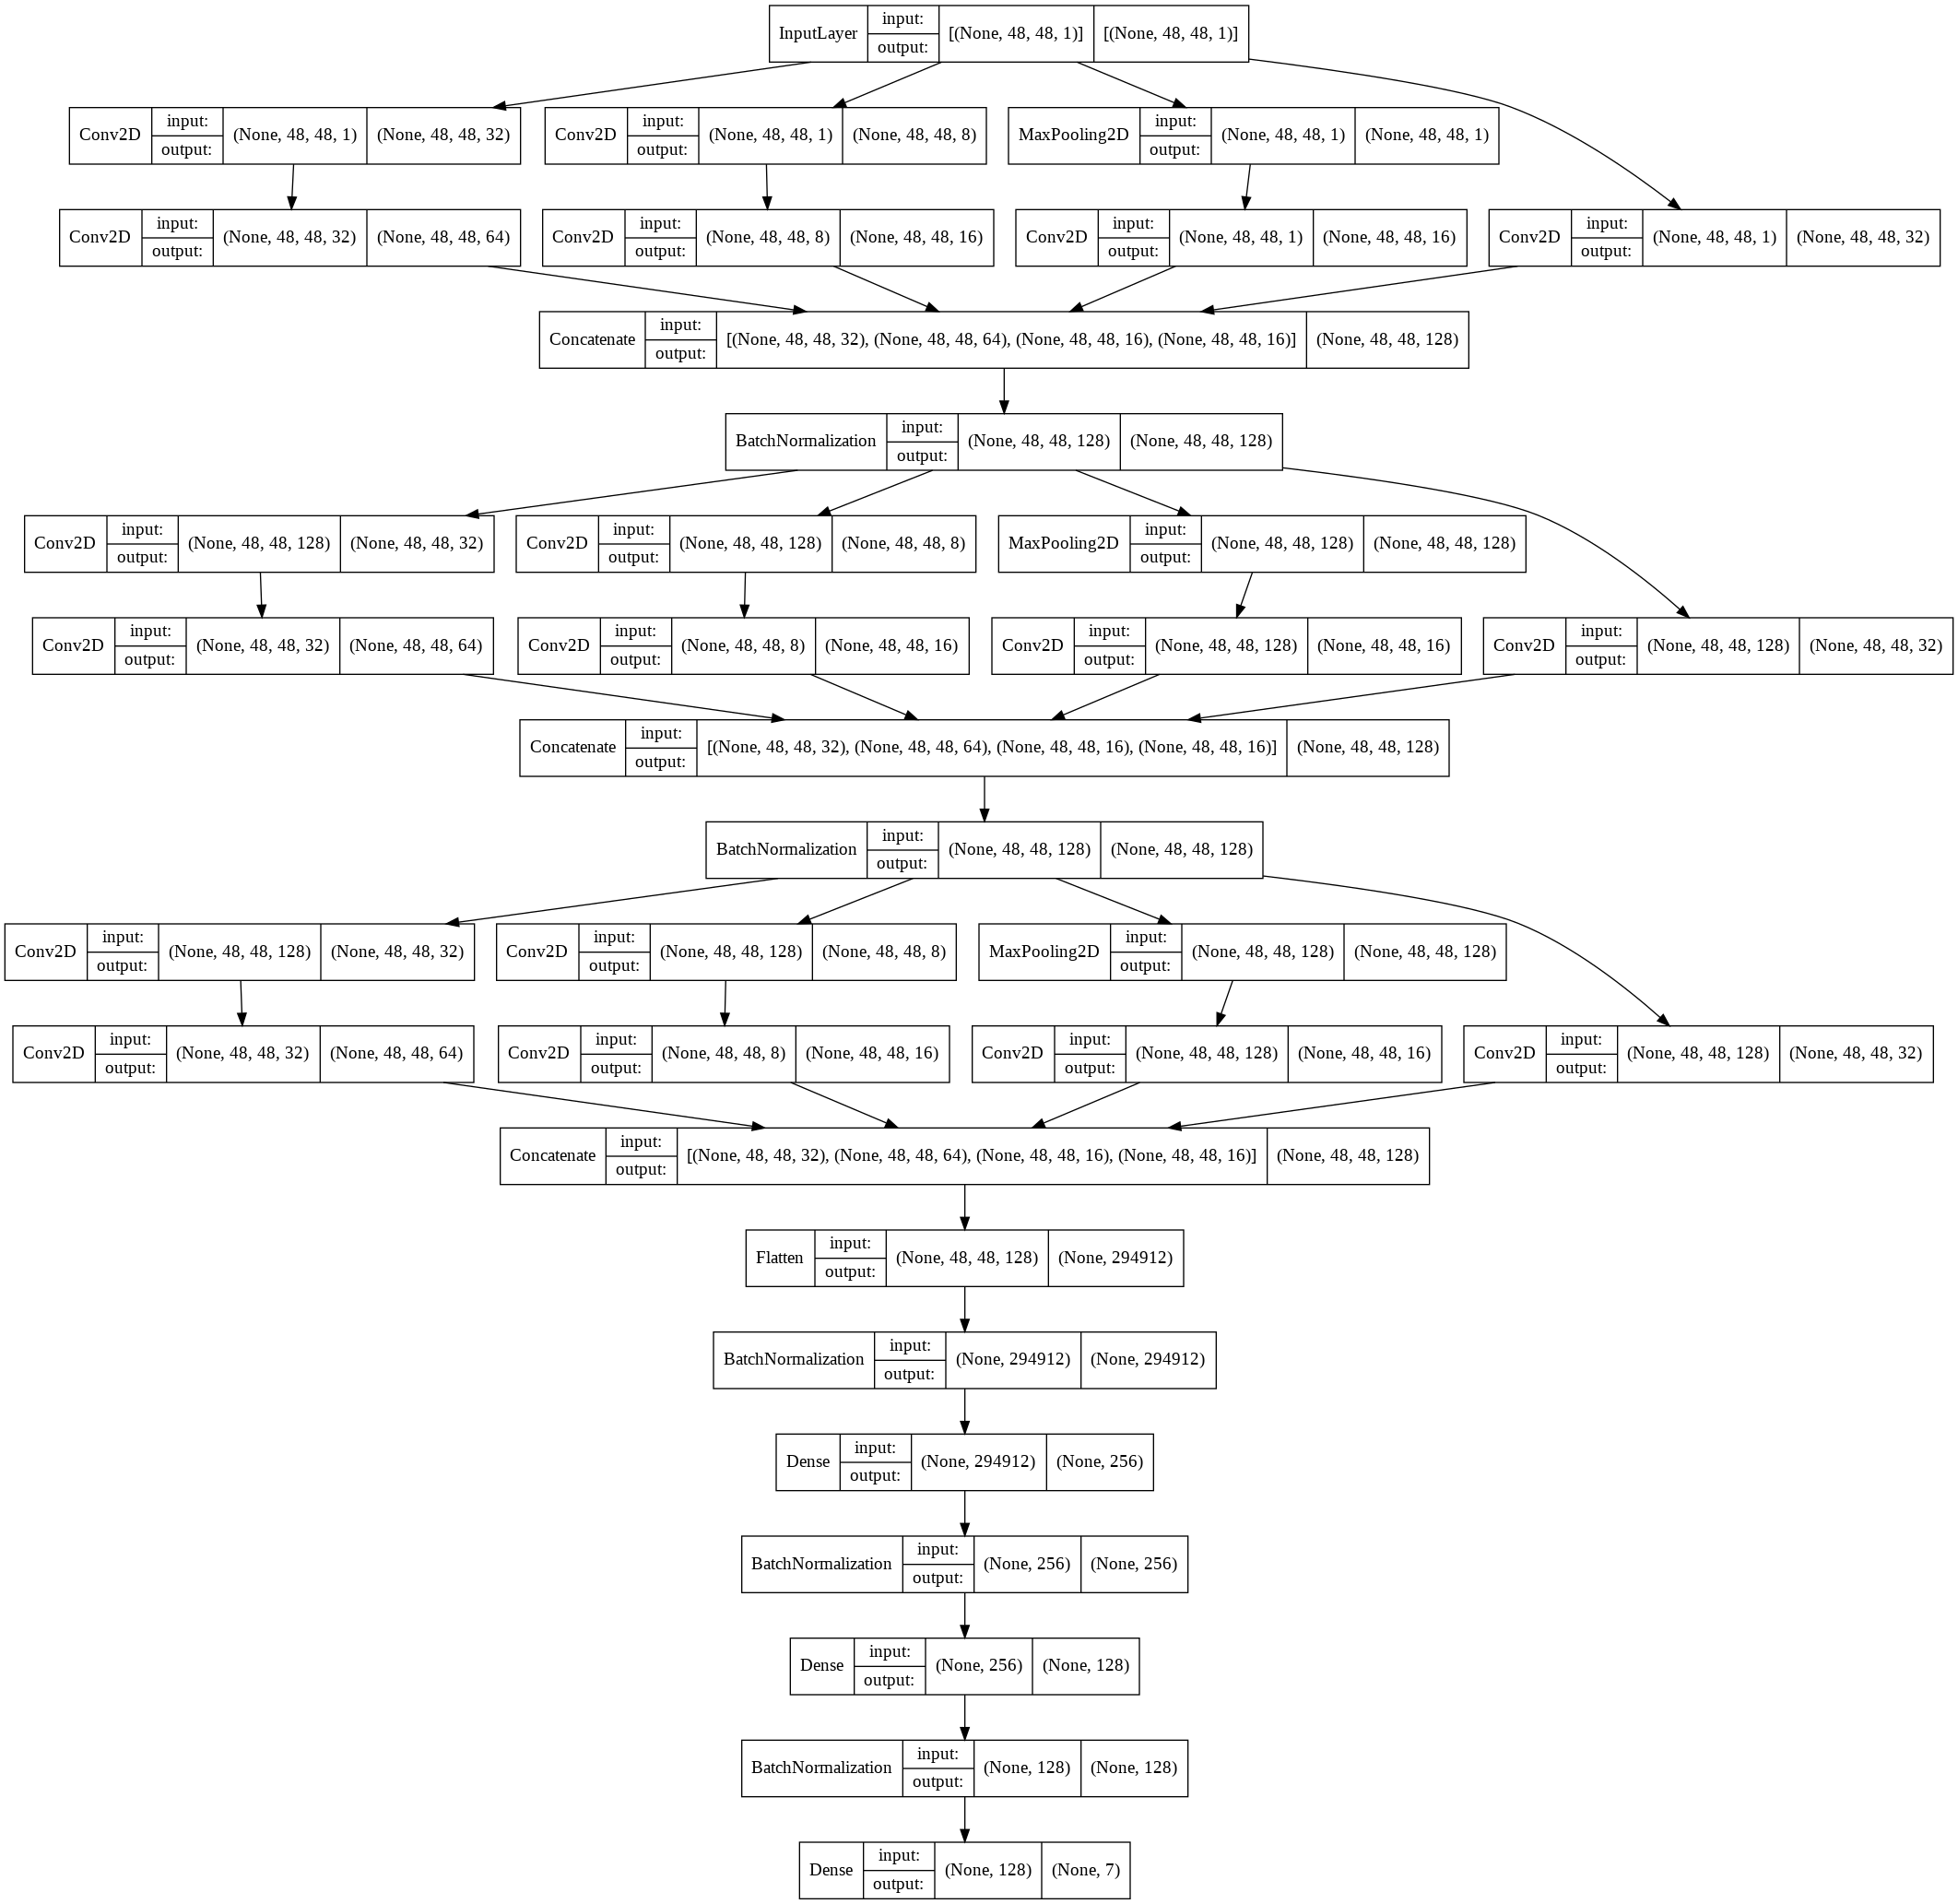

In [ ]:
# Plot model graph
plot_model(inception, show_shapes=True, to_file='inception.png', show_layer_names=False)

In [ ]:
# Fitting the model
inception_history = inception.fit_generator(generator=train_data,
                                            steps_per_epoch=train_data.n//train_data.batch_size,
                                            epochs=50,
                                            validation_data = validation,
                                            validation_steps = validation.n//validation.batch_size,
                                            callbacks=callback_list('inception')
                                            )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.8615 - accuracy: 0.2927WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 55s 118ms/step - loss: 1.8615 - accuracy: 0.2927 - val_loss: 2.0390 - val_accuracy: 0.2521 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.6560 - accuracy: 0.3704WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.6560 - accuracy: 0.3704 - val_loss: 1.6296 - val_accuracy: 0.3744 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.5631 - accuracy: 0.4043WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.5631 - accuracy: 0.4043 - val_loss: 1.5546 - val_accuracy: 0.4173 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.5010 - accuracy: 0.4307WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.5010 - accuracy: 0.4307 - val_loss: 1.6016 - val_accuracy: 0.4011 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - ETA: 0s - loss: 1.4500 - accuracy: 0.4499WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.4500 - accuracy: 0.4499 - val_loss: 1.5127 - val_accuracy: 0.4322 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - ETA: 0s - loss: 1.4057 - accuracy: 0.4639WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.4057 - accuracy: 0.4639 - val_loss: 1.3791 - val_accuracy: 0.4732 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============================] - ETA: 0s - loss: 1.3739 - accuracy: 0.4752WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.3739 - accuracy: 0.4752 - val_loss: 1.4201 - val_accuracy: 0.4555 - lr: 1.0000e-04
Epoch 8/50
448/448 [==============================] - ETA: 0s - loss: 1.3405 - accuracy: 0.4889WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.3405 - accuracy: 0.4889 - val_loss: 1.3275 - val_accuracy: 0.5038 - lr: 1.0000e-04
Epoch 9/50
448/448 [==============================] - ETA: 0s - loss: 1.3084 - accuracy: 0.4990WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.3084 - accuracy: 0.4990 - val_loss: 1.3287 - val_accuracy: 0.4965 - lr: 1.0000e-04
Epoch 10/50
448/448 [==============================] - ETA: 0s - loss: 1.2802 - accuracy: 0.5161WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 51s 114ms/step - loss: 1.2802 - accuracy: 0.5161 - val_loss: 1.4201 - val_accuracy: 0.4669 - lr: 1.0000e-04
Epoch 11/50
448/448 [==============================] - ETA: 0s - loss: 1.2633 - accuracy: 0.5209WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.2633 - accuracy: 0.5209 - val_loss: 1.2181 - val_accuracy: 0.5456 - lr: 1.0000e-04
Epoch 12/50
448/448 [==============================] - ETA: 0s - loss: 1.2408 - accuracy: 0.5304WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.2408 - accuracy: 0.5304 - val_loss: 1.2916 - val_accuracy: 0.5144 - lr: 1.0000e-04
Epoch 13/50
448/448 [==============================] - ETA: 0s - loss: 1.2159 - accuracy: 0.5376WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 51s 114ms/step - loss: 1.2159 - accuracy: 0.5376 - val_loss: 1.3556 - val_accuracy: 0.5013 - lr: 1.0000e-04
Epoch 14/50
448/448 [==============================] - ETA: 0s - loss: 1.2026 - accuracy: 0.5476WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 52s 116ms/step - loss: 1.2026 - accuracy: 0.5476 - val_loss: 1.4072 - val_accuracy: 0.4742 - lr: 1.0000e-04
Epoch 15/50
448/448 [==============================] - ETA: 0s - loss: 1.1566 - accuracy: 0.5654WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 51s 114ms/step - loss: 1.1566 - accuracy: 0.5654 - val_loss: 1.2193 - val_accuracy: 0.5416 - lr: 2.0000e-05
Epoch 16/50
448/448 [==============================] - ETA: 0s - loss: 1.1462 - accuracy: 0.5656WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 117ms/step - loss: 1.1462 - accuracy: 0.5656 - val_loss: 1.2075 - val_accuracy: 0.5465 - lr: 2.0000e-05
Epoch 17/50
448/448 [==============================] - ETA: 0s - loss: 1.1317 - accuracy: 0.5765WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.1317 - accuracy: 0.5765 - val_loss: 1.1739 - val_accuracy: 0.5559 - lr: 2.0000e-05
Epoch 18/50
448/448 [==============================] - ETA: 0s - loss: 1.1263 - accuracy: 0.5763WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 117ms/step - loss: 1.1263 - accuracy: 0.5763 - val_loss: 1.1716 - val_accuracy: 0.5615 - lr: 2.0000e-05
Epoch 19/50
448/448 [==============================] - ETA: 0s - loss: 1.1182 - accuracy: 0.5810WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.1182 - accuracy: 0.5810 - val_loss: 1.1609 - val_accuracy: 0.5707 - lr: 2.0000e-05
Epoch 20/50
448/448 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.5836WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.1069 - accuracy: 0.5836 - val_loss: 1.1681 - val_accuracy: 0.5649 - lr: 2.0000e-05
Epoch 21/50
448/448 [==============================] - ETA: 0s - loss: 1.1011 - accuracy: 0.5861WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 51s 115ms/step - loss: 1.1011 - accuracy: 0.5861 - val_loss: 1.1649 - val_accuracy: 0.5654 - lr: 2.0000e-05
Epoch 22/50
448/448 [==============================] - ETA: 0s - loss: 1.0993 - accuracy: 0.5871WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.0993 - accuracy: 0.5871 - val_loss: 1.1573 - val_accuracy: 0.5667 - lr: 2.0000e-05
Epoch 23/50
448/448 [==============================] - ETA: 0s - loss: 1.0896 - accuracy: 0.5919WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.0896 - accuracy: 0.5919 - val_loss: 1.1617 - val_accuracy: 0.5679 - lr: 2.0000e-05
Epoch 24/50
448/448 [==============================] - ETA: 0s - loss: 1.0832 - accuracy: 0.5936WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 51s 114ms/step - loss: 1.0832 - accuracy: 0.5936 - val_loss: 1.1700 - val_accuracy: 0.5646 - lr: 2.0000e-05
Epoch 25/50
448/448 [==============================] - ETA: 0s - loss: 1.0800 - accuracy: 0.5927WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 25: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 [==============================] - 52s 115ms/step - loss: 1.0800 - accuracy: 0.5927 - val_loss: 1.1951 - val_accuracy: 0.5575 - lr: 2.0000e-05
Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 1.0693 - accuracy: 0.5981WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.0693 - accuracy: 0.5981 - val_loss: 1.1455 - val_accuracy: 0.5755 - lr: 4.0000e-06
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 1.0671 - accuracy: 0.6001WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.0671 - accuracy: 0.6001 - val_loss: 1.1318 - val_accuracy: 0.5801 - lr: 4.0000e-06
Epoch 28/50
448/448 [==============================] - ETA: 0s - loss: 1.0618 - accuracy: 0.6018WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 51s 114ms/step - loss: 1.0618 - accuracy: 0.6018 - val_loss: 1.1327 - val_accuracy: 0.5808 - lr: 4.0000e-06
Epoch 29/50
448/448 [==============================] - ETA: 0s - loss: 1.0609 - accuracy: 0.6055WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.0609 - accuracy: 0.6055 - val_loss: 1.1346 - val_accuracy: 0.5788 - lr: 4.0000e-06
Epoch 30/50
448/448 [==============================] - ETA: 0s - loss: 1.0632 - accuracy: 0.6007WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 30: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
448/448 [==============================] - 52s 115ms/step - loss: 1.0632 - accuracy: 0.6007 - val_loss: 1.1329 - val_accuracy: 0.5837 - lr: 4.0000e-06
Epoch 31/50
448/448 [==============================] - ETA: 0s - loss: 1.0578 - accuracy: 0.6059WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.0578 - accuracy: 0.6059 - val_loss: 1.1355 - val_accuracy: 0.5783 - lr: 8.0000e-07
Epoch 32/50
448/448 [==============================] - ETA: 0s - loss: 1.0577 - accuracy: 0.6044WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 115ms/step - loss: 1.0577 - accuracy: 0.6044 - val_loss: 1.1356 - val_accuracy: 0.5801 - lr: 8.0000e-07
Epoch 33/50
448/448 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.6053WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 33: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
448/448 [==============================] - 52s 116ms/step - loss: 1.0575 - accuracy: 0.6053 - val_loss: 1.1380 - val_accuracy: 0.5787 - lr: 8.0000e-07
Epoch 34/50
448/448 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.6035WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 51s 114ms/step - loss: 1.0588 - accuracy: 0.6035 - val_loss: 1.1359 - val_accuracy: 0.5781 - lr: 1.6000e-07
Epoch 35/50
448/448 [==============================] - ETA: 0s - loss: 1.0510 - accuracy: 0.6056WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 52s 116ms/step - loss: 1.0510 - accuracy: 0.6056 - val_loss: 1.1355 - val_accuracy: 0.5798 - lr: 1.6000e-07
Epoch 36/50
448/448 [==============================] - ETA: 0s - loss: 1.0578 - accuracy: 0.6039Restoring model weights from the end of the best epoch: 27.



Epoch 36: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.
448/448 [==============================] - 51s 115ms/step - loss: 1.0578 - accuracy: 0.6039 - val_loss: 1.1365 - val_accuracy: 0.5780 - lr: 1.6000e-07
Epoch 36: early stopping


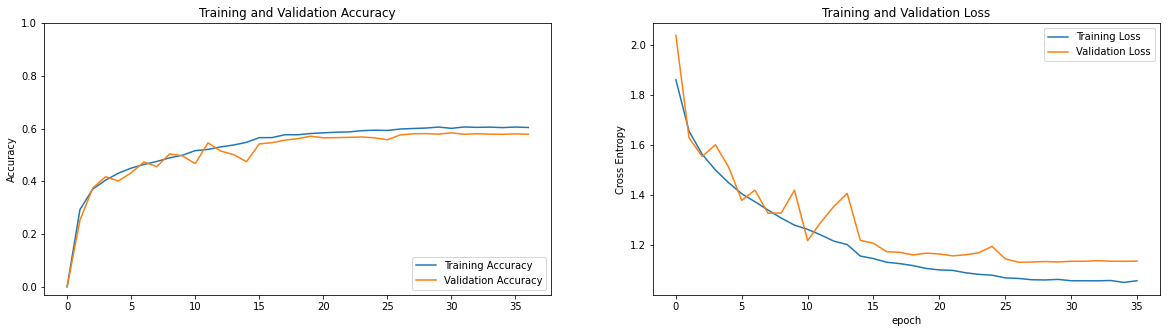

In [ ]:
# Plotting the accuracy and loss
plots(inception_history)

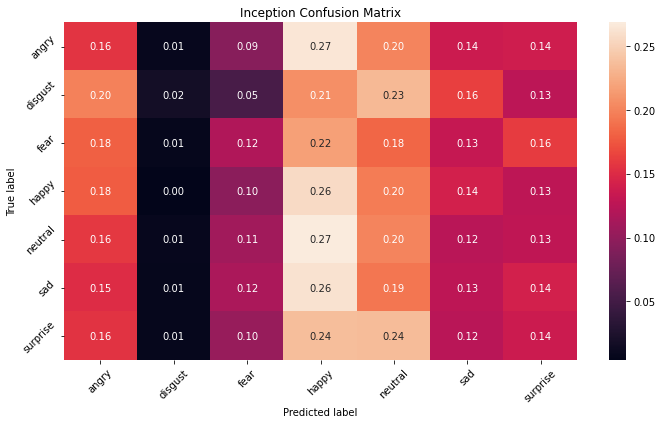

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=inception, model_name='inception')

In [ ]:
# Saving the model
inception.save('/content/drive/MyDrive/inception.h5')

<a name='11'></a>
# **Resnet**

In [ ]:
# Experimenting categorical classification using ResNet.
resnet = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for resnet
                     Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                     # Using resnet152
                     ResNet152(weights='imagenet', include_top=False, pooling='max'),
                     Flatten(), BatchNormalization(),
                     # Using 2 fully connected layers with relu activation
                     Dense(128, activation='relu'), BatchNormalization(),
                     Dense(64, activation='relu'), BatchNormalization(),
                     # Using a prediction layer with seven neuron
                     Dense(7, activation='softmax')])
 

# Compiling the model
resnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
resnet.summary()

234708992/234698864 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_22 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_27 (Dense)            (None, 128)               262272    
                                                                 
 batch_normalization_23 (Bat  (None, 128)            

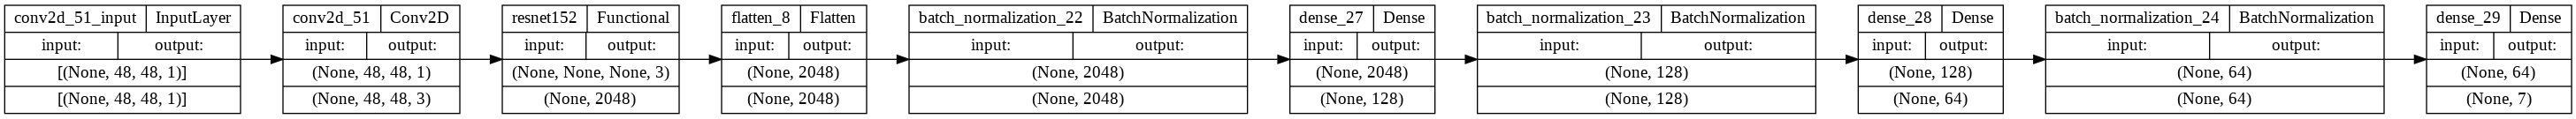

In [ ]:
# Plot model graph
plot_model(resnet, show_shapes=True, to_file='resnet.png', rankdir='LR')

In [ ]:
# Fitting the model
resnet_history = resnet.fit_generator(generator=train_data,
                                      steps_per_epoch=train_data.n//train_data.batch_size,
                                      epochs=50,
                                      validation_data = validation,
                                      validation_steps = validation.n//validation.batch_size,
                                      callbacks=callback_list('resnet')
                                      )

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.9048 - accuracy: 0.2997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 110s 198ms/step - loss: 1.9048 - accuracy: 0.2997 - val_loss: 8.7034 - val_accuracy: 0.1332 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.5684 - accuracy: 0.4146WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 81s 180ms/step - loss: 1.5684 - accuracy: 0.4146 - val_loss: 1.8469 - val_accuracy: 0.2687 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.4534 - accuracy: 0.4552WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 84s 188ms/step - loss: 1.4534 - accuracy: 0.4552 - val_loss: 1.3266 - val_accuracy: 0.5064 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.3707 - accuracy: 0.4821WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 80s 179ms/step - loss: 1.3707 - accuracy: 0.4821 - val_loss: 1.2636 - val_accuracy: 0.5201 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - ETA: 0s - loss: 1.3106 - accuracy: 0.5086WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 81s 180ms/step - loss: 1.3106 - accuracy: 0.5086 - val_loss: 1.2245 - val_accuracy: 0.5435 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - ETA: 0s - loss: 1.2775 - accuracy: 0.5174WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 80s 179ms/step - loss: 1.2775 - accuracy: 0.5174 - val_loss: 1.4137 - val_accuracy: 0.5381 - lr: 1.0000e-04
Epoch 7/50
448/448 [==============================] - ETA: 0s - loss: 1.2348 - accuracy: 0.5355WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 84s 187ms/step - loss: 1.2348 - accuracy: 0.5355 - val_loss: 1.2402 - val_accuracy: 0.5504 - lr: 1.0000e-04
Epoch 8/50
448/448 [==============================] - ETA: 0s - loss: 1.2023 - accuracy: 0.5469WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 80s 179ms/step - loss: 1.2023 - accuracy: 0.5469 - val_loss: 1.1530 - val_accuracy: 0.5758 - lr: 1.0000e-04
Epoch 9/50
448/448 [==============================] - ETA: 0s - loss: 1.1497 - accuracy: 0.5683WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 85s 189ms/step - loss: 1.1497 - accuracy: 0.5683 - val_loss: 1.2353 - val_accuracy: 0.5759 - lr: 1.0000e-04
Epoch 10/50
448/448 [==============================] - ETA: 0s - loss: 1.1194 - accuracy: 0.5826WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 80s 179ms/step - loss: 1.1194 - accuracy: 0.5826 - val_loss: 1.5942 - val_accuracy: 0.5884 - lr: 1.0000e-04
Epoch 11/50
448/448 [==============================] - ETA: 0s - loss: 1.0915 - accuracy: 0.5895WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 80s 178ms/step - loss: 1.0915 - accuracy: 0.5895 - val_loss: 1.1366 - val_accuracy: 0.5880 - lr: 1.0000e-04
Epoch 12/50
448/448 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.6045WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 81s 180ms/step - loss: 1.0642 - accuracy: 0.6045 - val_loss: 1.1118 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 13/50
448/448 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.6021WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 80s 178ms/step - loss: 1.0588 - accuracy: 0.6021 - val_loss: 1.1979 - val_accuracy: 0.5834 - lr: 1.0000e-04
Epoch 14/50
448/448 [==============================] - ETA: 0s - loss: 1.0721 - accuracy: 0.6007WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 78s 175ms/step - loss: 1.0721 - accuracy: 0.6007 - val_loss: 1.1684 - val_accuracy: 0.5711 - lr: 1.0000e-04
Epoch 15/50
448/448 [==============================] - ETA: 0s - loss: 1.1251 - accuracy: 0.5723WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 15: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 84s 186ms/step - loss: 1.1251 - accuracy: 0.5723 - val_loss: 1.2794 - val_accuracy: 0.5451 - lr: 1.0000e-04
Epoch 16/50
448/448 [==============================] - ETA: 0s - loss: 1.0228 - accuracy: 0.6185WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 80s 178ms/step - loss: 1.0228 - accuracy: 0.6185 - val_loss: 1.0723 - val_accuracy: 0.6060 - lr: 2.0000e-05
Epoch 17/50
448/448 [==============================] - ETA: 0s - loss: 0.9778 - accuracy: 0.6342WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 79s 176ms/step - loss: 0.9778 - accuracy: 0.6342 - val_loss: 1.0960 - val_accuracy: 0.6073 - lr: 2.0000e-05
Epoch 18/50
448/448 [==============================] - ETA: 0s - loss: 0.9550 - accuracy: 0.6449WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 79s 175ms/step - loss: 0.9550 - accuracy: 0.6449 - val_loss: 1.0454 - val_accuracy: 0.6194 - lr: 2.0000e-05
Epoch 19/50
448/448 [==============================] - ETA: 0s - loss: 0.9361 - accuracy: 0.6504WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 79s 177ms/step - loss: 0.9361 - accuracy: 0.6504 - val_loss: 1.1483 - val_accuracy: 0.6120 - lr: 2.0000e-05
Epoch 20/50
448/448 [==============================] - ETA: 0s - loss: 0.9102 - accuracy: 0.6599WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 78s 175ms/step - loss: 0.9102 - accuracy: 0.6599 - val_loss: 1.0735 - val_accuracy: 0.6172 - lr: 2.0000e-05
Epoch 21/50
448/448 [==============================] - ETA: 0s - loss: 0.9059 - accuracy: 0.6633WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 21: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 [==============================] - 84s 187ms/step - loss: 0.9059 - accuracy: 0.6633 - val_loss: 1.1708 - val_accuracy: 0.6064 - lr: 2.0000e-05
Epoch 22/50
448/448 [==============================] - ETA: 0s - loss: 0.8793 - accuracy: 0.6718WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 79s 176ms/step - loss: 0.8793 - accuracy: 0.6718 - val_loss: 1.0876 - val_accuracy: 0.6141 - lr: 4.0000e-06
Epoch 23/50
448/448 [==============================] - ETA: 0s - loss: 0.8711 - accuracy: 0.6750WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 78s 175ms/step - loss: 0.8711 - accuracy: 0.6750 - val_loss: 1.0731 - val_accuracy: 0.6183 - lr: 4.0000e-06
Epoch 24/50
448/448 [==============================] - ETA: 0s - loss: 0.8678 - accuracy: 0.6754WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 24: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
448/448 [==============================] - 84s 186ms/step - loss: 0.8678 - accuracy: 0.6754 - val_loss: 1.1251 - val_accuracy: 0.6176 - lr: 4.0000e-06
Epoch 25/50
448/448 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.6798WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 79s 177ms/step - loss: 0.8585 - accuracy: 0.6798 - val_loss: 1.1510 - val_accuracy: 0.6173 - lr: 8.0000e-07
Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 0.8600 - accuracy: 0.6829WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 78s 175ms/step - loss: 0.8600 - accuracy: 0.6829 - val_loss: 1.1620 - val_accuracy: 0.6179 - lr: 8.0000e-07
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 0.8489 - accuracy: 0.6860Restoring model weights from the end of the best epoch: 18.



Epoch 27: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
448/448 [==============================] - 79s 175ms/step - loss: 0.8489 - accuracy: 0.6860 - val_loss: 1.2062 - val_accuracy: 0.6165 - lr: 8.0000e-07
Epoch 27: early stopping


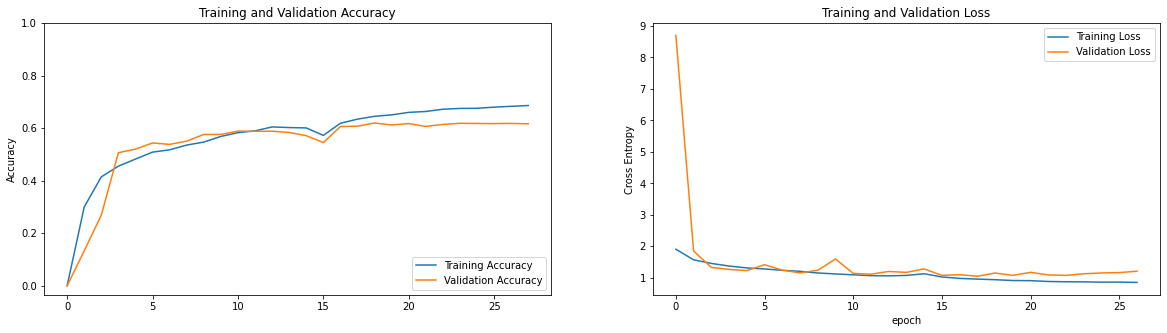

In [ ]:
# Plotting the accuracy and loss
plots(resnet_history)

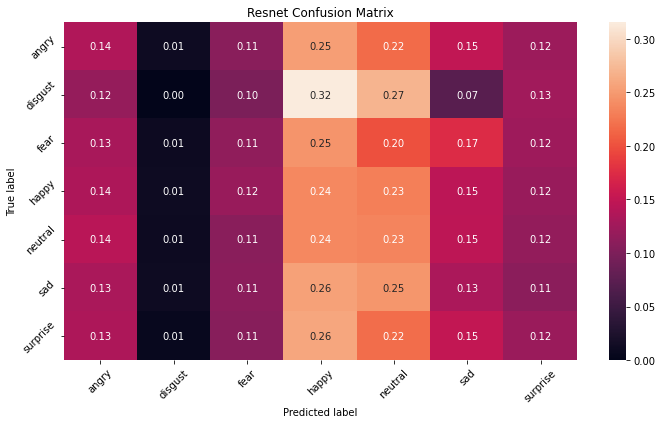

In [ ]:
# Plotting the normalized confusion matrix
plotc(model=resnet, model_name='resnet')

In [ ]:
# Saving the model
resnet.save('/content/drive/MyDrive/resnet.h5')